In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import matplotlib
import pydot
import pickle
import pathlib
import os
from scipy import stats
import random
from sklearn.metrics import r2_score
from sklearn.metrics import mutual_info_score

plt.rcParams['figure.figsize'] = [10, 5]
#import unicode

from scipy.optimize import curve_fit
import re
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import statistics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
import networkx as nx
from operator import itemgetter
from scipy.spatial import distance_matrix

from collections import Counter

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

import seaborn
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.spatial import distance


In [2]:
#directory = str(pathlib.Path(__file__).parent.resolve())
#script_path = str(pathlib.Path(__file__).parent.resolve())
directory = os.getcwd()
script_path = os.getcwd()
nameset,dictset = [],[]
refnameset,refdictset = [],[]

refsortset = []
sortset = []


for filename in os.listdir(directory):
    if filename.endswith(".txt") and '._' not in filename:
        if 'REF' not in filename:
            impath = os.path.join(directory, filename)
            nameset.append(impath)
            this_set = dict()
            with (open(impath, encoding = 'utf8', errors = 'ignore')) as f: #populate dict from text file
                for n in f:
                    pog = n.split('\t')
                    this_set[pog[0]] = pog[-1].count(',') * 1.25
                f.close()
            try:
                this_set.pop('cell_name')
                this_set.pop('AB')
            except: pass
            dictset.append(this_set)
            sortset.append((impath, this_set))
        else:
            impath = os.path.join(directory, filename)
            refnameset.append(impath)
            this_set = dict()
            with (open(impath, encoding = 'utf8', errors = 'ignore')) as f: #populate dict from text file
                for n in f:
                    pog = n.split('\t')
                    this_set[pog[0]] = pog[-1].count(',') * 1.25
                f.close()
            try:
                this_set.pop('cell_name')
                this_set.pop('AB')
            except: pass
            refdictset.append(this_set)
            refsortset.append((impath, this_set))
    
print(len(dictset),len(nameset))
print(len(refdictset),len(refnameset))
truncator = len(nameset)

nameset,dictset = [],[]
for n in sorted(sortset):
    nameset.append(n[0]);dictset.append(n[1])

refnameset,refdictset = [],[]
for n in sorted(refsortset):
    refnameset.append(n[0]);refdictset.append(n[1])

1322 1322
30 30


In [3]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0))
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 25)
    plt.show()

In [4]:
def remove_dangling_children(oldshi):
    poor = list(oldshi);dishi = dict()
    for n in range(1,len(poor)-1):
        if (len(poor[n]) == len(poor[n+1]) or len(poor[n]) == len(poor[n-1])) == False: dishi[poor[n]] = oldshi[poor[n]]
    return dishi

#'''
nameset,dictset = [],[]
for n in sorted(sortset):
    nameset.append(n[0]);dictset.append(remove_dangling_children(n[1]))
    
refnameset,refdictset = [],[]
for n in sorted(refsortset):
    refnameset.append(n[0]);refdictset.append(remove_dangling_children(n[1]))
#'''

In [5]:
#part 1 of common node
refnodelist = set(refdictset[0])
for n in refdictset:
    refnodelist = set(n).intersection(refnodelist)

In [6]:
#part 2 of common node
newdictset = []
for n in refdictset:
    newdict = dict()
    for i in refnodelist:
        newdict[i] = n[i]
    #print(set(newdict).issubset(set(n)))
    #print(len(newdict))
    newdictset.append(newdict)

#print(set(newdict).issubset(set(n)))
refdictset = newdictset

In [7]:
def Parent_node_finder(child):
    if child == 'E' or child == 'MS':
        return 'EMS'
    if child == 'D' or child == 'P4':
        return 'P3'
    if child == 'P3' or child == 'C':
        return 'P2'
    if child == 'P2' or child == 'EMS':
        return 'P1'
    return child[:-1]

def sibling_node_finder(bro):
    siblingdict = {'E':'MS', 'MS':'E',
                   'D':'P4', 'P4':'D',
                   'C':'P3', 'P3':'C',
                   'EMS':'P2', 'P2':'EMS',
                   'AB':'P1', 'P1':'AB'
                  }
    
    orididct = {'a':'p', 'p':'a',
                'r':'l', 'l':'r',
                'd':'v', 'v':'d'}
    try:
        return siblingdict[bro]
    except:
        return bro[:-1] + orididct[bro[-1]]

def strange_child_node_finder(mom):
    children_dict = {
        'EMS':('E','MS'),
        'P3':('D','P4'),
        'P2':('P3','C'),
        'P1':('P2','EMS'),
        'P0':('AB','P1')
    }
    try:
        return children_dict[mom]
    except:
        return mom

def scramble(dict_list):
    dict_return = []
    for element in dict_list:
        valuescramble = list(element.values())
        random.shuffle(valuescramble)
        keyscramble = list(element)
        random.shuffle(keyscramble)
        new_element = dict()
        for n in range(0,len(keyscramble)):
            new_element[keyscramble[n]] = valuescramble[n]
        dict_return.append(new_element)
    return dict_return
def globalize(dictn):
    globaldictset = []
    for i in dictn:
        tags = sorted(list(i));dip = dict()
        for n in tags:
            try:
                dip[n] = i[n] + dip[Parent_node_finder(n)]
            except: dip[n] = i[n]
        globaldictset.append(dip)
    return globaldictset

def adjuster(dictn,gdictn):
    for n in range(len(dictn)):
        for nn in gdictn[n]:
            gdictn[n][nn] = gdictn[n][nn] - dictn[n][nn]

In [8]:
scrambledictset = scramble(dictset)
globaldictset = globalize(dictset)
globalscrambledictset = globalize(scrambledictset)

refscrambledictset = scramble(refdictset)
refglobaldictset = globalize(refdictset)
refglobalscrambledictset = globalize(refscrambledictset)

In [9]:
adjuster(dictset,globaldictset)

adjuster(refdictset,refglobaldictset)

adjuster(scrambledictset,globalscrambledictset)

adjuster(refscrambledictset, refglobalscrambledictset)

In [10]:
def tree_edit_distance(dict1,dict2): return (len((set(dict1).union(set(dict2))))-len((set(dict1).intersection(set(dict2)))))

def branch_distance(dict1,dict2): #issa metric from deeds
    branch_dist = 0
    for n in list(set(dict1).intersection(set(dict2))):
        branch_dist = branch_dist + (dict1[n]-dict2[n])**2
        #print(n,(dict1[n]-dict2[n])**2, branch_dist)
    return (np.sqrt(branch_dist))

def jaccard_distance(dict1,dict2):
    onion = len(set(dict1).union(set(dict2)))
    entry = len(set(dict1).intersection(set(dict2)))
    #print((onion - len(set(dict1).intersection(set(dict2)))) / onion)
    return ((onion - len(set(dict1).intersection(set(dict2)))) / onion)
    #return (len((set(dict1).union(set(dict2))))-len((set(dict1).intersection(set(dict2)))))

def variable_nodes(dict1,root_node):
    tip = dict()
    for n in [x for x in dict1 if re.search(root_node, x)]: tip[n] = dict1[n]
    return tip

def node_comparison_trimmer(dict0,root_node):
    dict1 = dict(dict0)
    tip = dict()
    if root_node == 'EMS':
        root_node = 'Q'
        for n in [x for x in dict1 if re.search('E', x) or re.search('MS', x)]:
            if n == 'EMS':
                dict1['Q'] = dict1[n]
            if n[0] == 'E':
                dict1['Qp'+n[1:]] = dict1[n]
            elif n == 'MS' : dict1['Qp'] = dict1['MS']
            else:
                dict1['Qa'+n[2:]] = dict1[n]
    elif root_node == 'P2':
        root_node = 'Q'
        try:
            dict1['P3'] = dict1['Ql']
        except:
            pass
        for n in [x for x in dict1 if re.search('C', x) or re.search('D', x)]:
            if n[0] == 'C':
                dict1['Qr'+n[1:]] = dict1[n]
            else:
                dict1['Qrr'+n[1:]] = dict1[n]
    elif root_node == 'P3':
        root_node = 'Q'
        try:
            dict1['P4'] = dict1['Ql']
        except:
            pass
        for n in [x for x in dict1 if re.search('D', x)]:
            dict1['Qr'+n[1:]] = dict1[n]
    for n in [x for x in dict1 if re.search(root_node, x)]: 
        m = n.replace('r', "p").replace('v', "p")
        m = m.replace('d', "a").replace('l', "a")
        m = m[len(root_node):]
        tip[m] = dict1[n]
    return tip

def novel_two_sample_permutation_test(list1,list2,its):
    ref_list = sorted([list1,list2], key = len)
    list1 = ref_list[0];list2 = ref_list[1]
    len1 = len(list1);len2 = len(list2)
    list1,list2 = np.array(list1),np.array(list2)
    reference_mean = np.mean(list1) - np.mean(list2)
    hist_list = []
    for n in range(0,its):
        pop15 = random.sample(range(0, len2), len1)
        full_list = np.concatenate((list1,list2[pop15]), axis=None)
        pop1 = random.sample(range(0, len(full_list)), len1);
        #print(pop1)
        pop2 = list(set(range(0, len(full_list))) - set(pop1))
        #print(pop2)
        resamp_mean = np.mean(full_list[pop1]) - np.mean(full_list[pop2])
        hist_list.append(resamp_mean)
    #plt.hist(hist_list)
    hist_list = np.array(hist_list)
    if reference_mean < 0:
        p = np.sum(hist_list <= reference_mean)/its
    else:
        p = np.sum(hist_list >= reference_mean)/its
    return p

def subtree_comparison_to_WT(WT_dict,RNAi_dict, root):
    reference = node_comparison_trimmer(RNAi_dict,root); huld = []
    for n in root_cells_comp:
        huld.append(branch_distance(reference, node_comparison_trimmer(WT_dict,n)))
    return np.array(huld)

def self_comp(imp_mat):
    imp_mat = np.mat(imp_mat)
    imp_mat = np.tril(np.array(imp_mat)).flatten()
    imp_mat = imp_mat[np.where(imp_mat != 0.0)]
    return (imp_mat)


def out_comp(imp_mat):
    imp_mat = np.mat(imp_mat)
    sample_size = int((min(imp_mat.shape) ** 2 - min(imp_mat.shape)) / 2)
    samples = np.random.choice(imp_mat.flatten().tolist()[0], sample_size)
    return ('mu',np.mean(samples),'var',np.var(samples))

def out_comp(imp_mat):
    imp_mat = np.mat(imp_mat)
    sample_size = int((min(imp_mat.shape) ** 2 - min(imp_mat.shape)) / 2)
    samples = np.random.choice(imp_mat.flatten().tolist()[0], sample_size)
    return ('mu',np.mean(samples),'var',np.var(samples))

In [11]:
def siblingswap(dictn, sibling1):
    print(sibling1, sibling_node_finder(sibling1))

In [12]:
def recursive_strange_child_node_finder(x):
    questions = [x]
    unknowns = []
    answers = []
    for k in range(2):
        for n in questions:
            puts = strange_child_node_finder(n)
            if puts == n:
                answers.append(n)
            else:
                unknowns = unknowns + list(puts)
            print(unknowns, answers)
        questions = unknowns
        unknowns = []

In [13]:
def node_comparison_trimmer_2(dict0,root_node):
    dict1 = dict(dict0)
    tip = dict()
    if root_node == 'EMS':
        root_node = 'Q'
        for n in [x for x in dict1 if re.search('E', x) or re.search('MS', x)]:
            if n == 'EMS':
                dict1['Q'] = dict1[n]
            if n[0] == 'E':
                dict1['Qp'+n[1:]] = dict1[n]
            elif n == 'MS' : dict1['Qp'] = dict1['MS']
            else:
                dict1['Qa'+n[2:]] = dict1[n]
    elif root_node == 'P2':
        root_node = 'Q'
        try:
            dict1['P3'] = dict1['Ql']
        except:
            pass
        for n in [x for x in dict1 if re.search('C', x) or re.search('D', x)]:
            if n[0] == 'C':
                dict1['Qr'+n[1:]] = dict1[n]
            else:
                dict1['Qrr'+n[1:]] = dict1[n]
    elif root_node == 'P3':
        root_node = 'Q'
        try:
            dict1['P4'] = dict1['Ql']
        except:
            pass
        for n in [x for x in dict1 if re.search('D', x)]:
            dict1['Qr'+n[1:]] = dict1[n]
    for n in [x for x in dict1 if re.search(root_node, x)]: 
        m = n.replace('r', "p").replace('v', "p")
        m = m.replace('d', "a").replace('l', "a")
        m = m[len(root_node):]
        tip[m] = dict1[n]
    return tip

def rooted_node_comparison_trimmer_2(dict0,root_node):
    nct = node_comparison_trimmer_2(dict0,root_node)
    returner = dict()
    for n in nct:
        returner['N'+n] = nct[n]
    return returner

In [14]:
def full_dict_name_cleaner(dictn):
    sanitized_dict = dict()
    old_AB_dict = node_comparison_trimmer_2(refdictset[0],'AB');
    for n in old_AB_dict:
        sanitized_dict['Na' + n] = old_AB_dict[n]
    old_EMS_dict = node_comparison_trimmer_2(refdictset[0],'EMS');
    for n in old_EMS_dict:
        sanitized_dict['Npa' + n] = old_EMS_dict[n]
    old_P2_dict = node_comparison_trimmer_2(refdictset[0],'P2');
    for n in old_P2_dict:
        sanitized_dict['Npp' + n] = old_P2_dict[n]
    del sanitized_dict['NpapMS']
    return sanitized_dict

def AB_dict_name_cleaner(dictn):
    sanitized_dict = dict()
    old_AB_dict = node_comparison_trimmer_2(refdictset[0],'AB');
    for n in old_AB_dict:
        sanitized_dict['N' + n] = old_AB_dict[n]
    return sanitized_dict

def sanitized_dict_swap_storing_function(dictn):
    sanitized_dict_sibling_storer = dict()
    for n in sorted(dictn.items(), key = lambda x: len(x[0])):
        if sibling_node_finder(n[0]) not in sanitized_dict_sibling_storer and sibling_node_finder(sibling_node_finder(n[0])) in sanitized_dict:
            sanitized_dict_sibling_storer[n[0]] = 0
    return sanitized_dict_sibling_storer

def sanitized_list_swap_storing_function(dictn):
    sanitized_dict_sibling_storer = []
    for n in sorted(dictn.items(), key = lambda x: len(x[0])):
        if sibling_node_finder(n[0]) not in sanitized_dict_sibling_storer and sibling_node_finder(sibling_node_finder(n[0])) in sanitized_dict:
            sanitized_dict_sibling_storer.append(n[0])
    return sanitized_dict_sibling_storer

In [15]:
def Cousin_swapping(dictn_og,root):
    dictn = dict(dictn_og)
    root_sibling = sibling_node_finder(root)
    burning_dict = dict()
    for n in dictn:
        if root in n:
            n_cousin_parallel = root_sibling + n.removeprefix(root)
            burning_dict[n] = dictn[n_cousin_parallel]
            burning_dict[n_cousin_parallel] = dictn[n]
    #return burning_dict
    return dictn | burning_dict

#Cousin_swapping(sample,'Npaa')

In [16]:
def Find_number_of_children(dictn, root):
    counter = 0
    for n in dictn:
        if root in n: counter +=1
    return counter

#Find_number_of_children(sample, 'Naa')

In [17]:

def union_branch_distance(dict1,dict2): #issa metric from deeds
    branch_dist = 0
    merged = dict1 | dict2
    for n in list(merged):
        #print(n)
        try:
            #print(dict1[n],dict2[n])
            branch_dist += (dict1[n] - dict2[n])**2
        except:
            #print(merged[n], 0)
            branch_dist += (merged[n])**2
            pass
        #branch_dist = branch_dist + (dict1[n]-dict2[n])**2
        #print(n,(dict1[n]-dict2[n])**2, branch_dist)
    return (np.sqrt(branch_dist))

def intersection_branch_distance(dict1,dict2): #issa metric from deeds
    branch_dist = 0
    for n in list(set(dict1).intersection(set(dict2))):
        branch_dist = branch_dist + (dict1[n]-dict2[n])**2
        #print(n,(dict1[n]-dict2[n])**2, branch_dist)
    return (np.sqrt(branch_dist))

In [18]:
def remove_redundancies_list(dictn):
    rev_sorted_list = sorted(dictn.keys(), key = len)[::-1]
    reduntant_removed_list = []
    dicty = []
    for n in rev_sorted_list:
        try:
            if sibling_node_finder(n) in dictn and sibling_node_finder(n) not in dicty:
                if dictn[n] != dictn[sibling_node_finder(n)] and len(n) == len(rev_sorted_list[0]):
                    pass
                else:
                    dicty.append(n)
        except:
            pass
    return dicty

#remove_redundancies_list(sample)

In [19]:
#sample = rooted_node_comparison_trimmer_2(refdictset[0],'ABala')
def permute_binary_pairs(dictn,root):
    sample = rooted_node_comparison_trimmer_2(dictn,root)
    sample_iterated_array = np.array(remove_redundancies_list(sample))
    sample_iterated_array_usage = np.zeros(len(sample_iterated_array))
    for n in range(2**len(sample_iterated_array_usage)):
        index_swappers = np.array(list(map(int, list(format(n, '0'+str(len(sample_iterated_array_usage))+'b')))))[::-1]
        temp_dict = dict(sample)
        #print(n)
        for m in sample_iterated_array[np.where(index_swappers == 1)]:
            temp_dict = Cousin_swapping(temp_dict,m)
            print(m)
        print(union_branch_distance(sample,temp_dict))
    

#permute_binary_pairs(refdictset[0],'ABalp')

In [ ]:
def permute_and_compute_BD(sample,refsample):
    sample_iterated_array = np.array(remove_redundancies_list(sample))
    sample_iterated_array_usage = np.zeros(len(sample_iterated_array))
    for n in range(2**len(sample_iterated_array_usage)):
        index_swappers = np.array(list(map(int, list(format(n, '0'+str(len(sample_iterated_array_usage))+'b')))))[::-1]
        temp_dict = dict(sample)
        recorded_swaps = sample_iterated_array[np.where(index_swappers == 1)]
        print(recorded_swaps[::-1])
        for m in recorded_swaps:
            try:
                temp_dict = Cousin_swapping(temp_dict,m)#;print(m)
            except:
                pass
        print(union_branch_distance(refsample,temp_dict))

samp2 = rooted_node_comparison_trimmer_2(refdictset[0],'ABalp')
refsamp2 = rooted_node_comparison_trimmer_2(refdictset[1],'ABara')
permute_and_compute_BD(samp2,refsamp2)

In [21]:
def permute_and_compute_BD(sample,refsample):
    sample_iterated_array = np.array(remove_redundancies_list(sample))
    sample_iterated_array_usage = np.zeros(len(sample_iterated_array))
    min_BD = np.inf; min_AB_ali = []
    for n in range(2**len(sample_iterated_array_usage)):
        index_swappers = np.array(list(map(int, list(format(n, '0'+str(len(sample_iterated_array_usage))+'b')))))[::-1]
        temp_dict = dict(sample)
        recorded_swaps = sample_iterated_array[np.where(index_swappers == 1)]
        print(recorded_swaps[::-1])
        for m in recorded_swaps:
            try:
                temp_dict = Cousin_swapping(temp_dict,m)#;print(m)
            except:
                pass
        print(union_branch_distance(refsample,temp_dict))
        if min_BD > union_branch_distance(refsample,temp_dict):
            print('NEWMIN')
            min_BD = union_branch_distance(refsample,temp_dict)
            min_AB_ali = recorded_swaps
    return 

samp2 = rooted_node_comparison_trimmer_2(refdictset[0],'ABalp')
refsamp2 = rooted_node_comparison_trimmer_2(refdictset[1],'ABara')
#permute_and_compute_BD(samp2,refsamp2)

In [22]:
def permute_BD_alignment(sample,refsample):
    sample_iterated_array = np.array(remove_redundancies_list(sample))
    sample_iterated_array_usage = np.zeros(len(sample_iterated_array))
    min_BD = np.inf; min_alignment = []
    for n in range(2**len(sample_iterated_array_usage)):
        index_swappers = np.array(list(map(int, list(format(n, '0'+str(len(sample_iterated_array_usage))+'b')))))[::-1]
        temp_dict = dict(sample)
        recorded_swaps = sample_iterated_array[np.where(index_swappers == 1)]
        for m in recorded_swaps:
            try:
                temp_dict = Cousin_swapping(temp_dict,m)
            except:
                pass
        if min_BD > union_branch_distance(refsample,temp_dict):
            min_BD = union_branch_distance(refsample,temp_dict); 
            min_alignment = recorded_swaps
    return min_BD, min_alignment

samp2 = rooted_node_comparison_trimmer_2(refdictset[1],'ABplp')
refsamp2 = rooted_node_comparison_trimmer_2(refdictset[0],'ABarp')
permute_BD_alignment(samp2,refsamp2)

(39.250796170268956, array(['Napa', 'Nppa'], dtype='<U5'))

In [23]:
def permute_BD_function(sample,refsample):
    sample_iterated_array = np.array(remove_redundancies_list(sample))
    sample_iterated_array_usage = np.zeros(len(sample_iterated_array))
    min_BD = np.inf
    for n in range(2**len(sample_iterated_array_usage)):
        index_swappers = np.array(list(map(int, list(format(n, '0'+str(len(sample_iterated_array_usage))+'b')))))[::-1]
        temp_dict = dict(sample)
        recorded_swaps = sample_iterated_array[np.where(index_swappers == 1)]
        for m in recorded_swaps:
            try:
                temp_dict = Cousin_swapping(temp_dict,m)
            except:
                pass
        min_BD = min(min_BD,union_branch_distance(refsample,temp_dict))
    return min_BD

samp2 = rooted_node_comparison_trimmer_2(refdictset[1],'ABplp')
refsamp2 = rooted_node_comparison_trimmer_2(refdictset[0],'ABarp')
permute_BD_function(samp2,refsamp2)

39.250796170268956

In [ ]:
def permute_binary_pairs(dictn,root):
    sample = rooted_node_comparison_trimmer_2(dictn,root)
    sample_iterated_array = np.array(remove_redundancies_list(sample))
    sample_iterated_array_usage = np.zeros(len(sample_iterated_array))
    for n in range(2**len(sample_iterated_array_usage)):
        index_swappers = np.array(list(map(int, list(format(n, '0'+str(len(sample_iterated_array_usage))+'b')))))[::-1]
        temp_dict = dict(sample)
        #print(n)
        for m in sample_iterated_array[np.where(index_swappers == 1)]:
            temp_dict = Cousin_swapping(temp_dict,m)
            print(m)
        print(union_branch_distance(sample,temp_dict))
    

permute_binary_pairs(refdictset[0],'ABalp')

In [ ]:
def permute_and_compute_BD(sample,refsample):
    sample_iterated_array = np.array(remove_redundancies_list(sample))
    sample_iterated_array_usage = np.zeros(len(sample_iterated_array))
    min_BD = np.inf; min_AB_ali = []
    for n in range(2**len(sample_iterated_array_usage)):
        index_swappers = np.array(list(map(int, list(format(n, '0'+str(len(sample_iterated_array_usage))+'b')))))[::-1]
        temp_dict = dict(sample)
        recorded_swaps = sample_iterated_array[np.where(index_swappers == 1)]
        print(recorded_swaps[::-1])
        for m in recorded_swaps:
            try:
                temp_dict = Cousin_swapping(temp_dict,m)#;print(m)
            except:
                pass
        print(union_branch_distance(refsample,temp_dict))
        if min_BD > union_branch_distance(refsample,temp_dict):
            print('NEWMIN')
            min_BD = union_branch_distance(refsample,temp_dict)
            min_AB_ali = recorded_swaps
    return 

samp2 = rooted_node_comparison_trimmer_2(refdictset[0],'ABalp')
refsamp2 = rooted_node_comparison_trimmer_2(refdictset[1],'ABara')
permute_and_compute_BD(samp2,refsamp2)

In [26]:
def switch_impact(listn,dictn):
    counter = 0
    for n in listn:
        counter += Find_number_of_children(dictn,n)
    return counter

In [27]:
qf = pd.read_csv('1368-embryos.csv', header=None).iloc[0]
df = pd.read_csv('1368-embryos.csv')
rdf = df.sort_values(by = 'embryo-ID')
cuttags = ['ABa','ABp','C','D','E','MS','P']
rearranger = [0,1,4,5,3,2,6]

match_links = []
match_links2 = []

findit = 0
notin = 0

o = 0
for n in range(0,df.shape[0]):
    #print(rdf.iloc[n][1] in nameset[o])
    if rdf.iloc[n][1] in nameset[o]:
        #match_links.append((o,n)) #, o in nameset, #n in dataframe
        match_links.append(n) #index is o in nameset, list value is n in dataframe
        tagref = 0
        for nm in list(globaldictset[o]):
            if cuttags[tagref] not in nm:
                try:
                    tagref = tagref + 1
                    if tagref > 6:
                        break
                except:
                    break
            #findit = findit + (globaldictset[o][nm] >= rdf.iloc[n][rearranger[tagref]+5])
            if (globaldictset[o][nm] >= rdf.iloc[n][rearranger[tagref]+5] * 1.25): 
                #print(nameset[o].split('/')[-1])
                #print(rdf.iloc[n][1])
                #print('tag',o,'embryo',n,nm,globaldictset[o][nm],rdf.iloc[n][rearranger[tagref]+5])
                del dictset[o][nm]
        o = o + 1
    else:
        pass
        match_links2.append((o,-1))
        #match_links2.append(-1)


scrambledictset = scramble(dictset)
globaldictset = globalize(dictset)
globalscrambledictset = globalize(scrambledictset)

refscrambledictset = scramble(refdictset)
refglobaldictset = globalize(refdictset)
refglobalscrambledictset = globalize(refscrambledictset)

adjuster(dictset,globaldictset)

adjuster(refdictset,refglobaldictset)

adjuster(scrambledictset,globalscrambledictset)

adjuster(refscrambledictset, refglobalscrambledictset)

In [28]:
inlier_ref = [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 18, 21, 22, 23, 24, 25, 27, 28, 29]
#horticulture

In [29]:
fullnameset = refnameset + nameset
fulldictset = refdictset + dictset



root_cells_comp = ['ABa', 'ABp', 'ABal', 'ABar', 'ABpl', 'ABpr', 'ABala', 'ABalp', 'ABara', 'ABarp', 'ABpla', 'ABplp', 'ABpra', 'ABprp', 'EMS', 'P2', 'MS', 'E', 'C', 'P3', 'D']
inlier_ref = [0,2,3,4,5,6,7,11,12,13,14,15,16,18,21,22,23,24,25,27,28,29]

with open('RNAi_name_array.pickle', 'rb') as handle:
    RNAi_name_array = pickle.load(handle)

subtree_dict_list = []
for n in fulldictset:
    pack = dict()
    for m in root_cells_comp:
        pack[m] = len(node_comparison_trimmer(n,m))
    subtree_dict_list.append(pack)

RNAi_size_assignments = {'inlierWT': inlier_ref,
 'outlierWT': list(set(range(30)) - set(inlier_ref)),
 'ABI-1': [30, 31, 32, 33, 34, 35],
 'AMA-1': [36, 37, 38, 39, 40, 41],
 'AOS-1': [42, 43, 44, 45, 46, 47],
 'APR-1': [48, 49, 50, 51, 52, 53],
 'APX-1': [54, 55, 56, 57, 58, 59, 60, 61],
 'ARX-2': [62, 63, 64, 65, 66, 67],
 'ATX-2': [68, 69, 70, 71],
 'BUB-1': [72, 73, 74, 75, 76, 77],
 'C01A2.5': [78, 79, 80, 81, 82, 83],
 'C01F1.1': [84, 85, 86, 87, 88],
 'C02B10.5': [89, 90, 91, 92, 93, 94, 95],
 'C06A5.1': [96, 97, 98, 99, 100, 101, 102],
 'C07A9.2': [103, 104, 105, 106, 107, 108],
 'C08B11.3': [109, 110, 111, 112, 113, 114, 115],
 'C49H3.8': [116, 117, 118, 119, 120],
 'C50F2.3': [121, 122, 123, 124, 125, 126],
 'C55A6.9': [127, 128, 129, 130, 131, 132, 133],
 'CACN-1': [134, 135, 136, 137, 138, 139, 140, 141],
 'CAMT-1': [142, 143, 144, 145, 146],
 'CBP-1': [147, 148, 149, 150, 151, 152, 153],
 'CDC-25.1': [154, 155, 156, 157, 158, 159, 160],
 'CDC-37': [161, 162, 163, 164, 165, 166, 167, 168],
 'CDK-7': [169, 170, 171, 172, 173, 174, 175],
 'CDK-9': [176, 177, 178, 179, 180, 181],
 'CDT-1': [182, 183, 184, 185, 186, 187, 188],
 'CEH-24': [189, 190, 191, 192, 193, 194],
 'CHAF-2': [195, 196, 197, 198, 199, 200, 201],
 'CHC-1': [202, 203, 204, 205, 206, 207],
 'CHK-1': [208, 209, 210, 211, 212, 213, 214],
 'CIR-1': [215, 216, 217, 218, 219, 220],
 'CLPF-1': [221, 222, 223, 224, 225, 226],
 'CLS-2': [227, 228, 229, 230, 231, 232],
 'CMD-1': [233, 234, 235, 236, 237],
 'CPL-1': [238, 239, 240, 241, 242, 243, 244],
 'CPSF-1': [245, 246, 247, 248, 249, 250],
 'CPSF-2': [251, 252, 253, 254, 255, 256],
 'CPSF-4': [257, 258, 259, 260, 261, 262],
 'CSN-4': [263, 264, 265, 266, 267],
 'CUL-1': [268, 269, 270, 271, 272, 273, 274, 275, 276, 277],
 'CUL-2': [278, 279, 280, 281, 282, 283, 284, 285, 286],
 'CUL-3': [287, 288, 289, 290],
 'D1043.1': [291, 292, 293, 294, 295, 296],
 'D1054.14': [297, 298, 299, 300, 301, 302],
 'D1081.8': [303, 304, 305, 306, 307, 308, 309, 310],
 'D2096.8': [311, 312, 313, 314, 315],
 'DDX-23': [316, 317, 318, 319, 320, 321],
 'DIC-1': [322, 323, 324, 325, 326, 327, 328, 329, 330],
 'DIE-1': [331, 332, 333, 334, 335, 336, 337, 338],
 'DIV-1': [339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350],
 'DLC-1': [351, 352, 353, 354, 355],
 'DLI-1': [356, 357, 358, 359, 360, 361, 362],
 'DRH-3': [363, 364, 365, 366, 367, 368, 369, 370, 371, 372],
 'EGO-1': [373, 374, 375, 376, 377, 378, 379, 380, 381],
 'ELB-1': [382, 383, 384, 385, 386, 387, 388],
 'ELT-1': [389, 390, 391, 392, 393, 394],
 'EMB-5': [395, 396, 397, 398, 399, 400],
 'ETR-1': [401, 402, 403, 404, 405, 406, 407],
 'F19F10.9': [408, 409, 410, 411, 412, 413],
 'F20D12.2': [414, 415, 416, 417, 418, 419],
 'F23F1.5': [420, 421, 422, 423, 424, 425, 426],
 'F25B3.6': [427, 428, 429, 430, 431, 432],
 'F31C3.5': [433, 434, 435, 436, 437, 438, 439],
 'F35F11.1': [440, 441, 442, 443, 444, 445],
 'F37C12.1': [446, 447, 448, 449, 450],
 'F43E2.7': [451, 452, 453, 454, 455, 456, 457],
 'F43G9.12': [458, 459, 460, 461, 462, 463],
 'F44B9.8': [464, 465, 466, 467, 468, 469, 470],
 'F53B7.3': [471, 472, 473, 474, 475, 476, 477],
 'F55A3.7': [478, 479, 480, 481, 482, 483],
 'GAD-1': [484, 485, 486, 487, 488, 489, 490, 491, 492],
 'GEI-11': [493, 494, 495, 496, 497, 498],
 'GEI-17': [499, 500, 501, 502, 503, 504],
 'GLD-2': [505, 506, 507, 508, 509, 510, 511, 512, 513],
 'GLP-1': [514, 515, 516, 517, 518, 519, 520, 521],
 'GOP-2': [522, 523, 524, 525, 526, 527],
 'GPB-1': [528, 529, 530, 531, 532],
 'GSK-3': [533, 534, 535, 536, 537, 538, 539, 540, 541, 542],
 'HDA-1': [543, 544, 545, 546, 547, 548],
 'HEL-1': [549, 550, 551, 552, 553, 554],
 'HIM-10': [555, 556, 557, 558, 559, 560],
 'HIS-9': [561, 562, 563, 564, 565, 566],
 'HMP-2': [567, 568, 569, 570, 571, 572],
 'IMB-2': [573, 574, 575, 576, 577, 578],
 'K07C5.6': [579, 580, 581, 582, 583, 584],
 'KLP-10': [585, 586, 587, 588, 589, 590],
 'KLP-15': [591, 592, 593, 594, 595, 596, 597, 598],
 'KLP-16': [599, 600, 601, 602, 603, 604],
 'LAG-1': [605, 606, 607, 608, 609, 610, 611, 612],
 'LET-413': [613, 614, 615, 616, 617, 618],
 'LET-502': [619, 620, 621, 622, 623, 624],
 'LET-526': [625, 626, 627, 628, 629, 630],
 'LET-711': [631, 632, 633, 634, 635, 636, 637],
 'LIG-1': [638, 639, 640, 641, 642, 643, 644],
 'LIN-23': [645, 646, 647, 648, 649, 650, 651, 652],
 'LIN-26': [653, 654, 655, 656, 657],
 'LIN-53': [658, 659, 660, 661, 662, 663, 664],
 'LIT-1': [665, 666, 667, 668, 669, 670],
 'LRR-1': [671, 672, 673, 674, 675, 676, 677, 678, 679, 680],
 'M03C11.7': [681, 682, 683, 684, 685, 686],
 'MBK-2': [687, 688, 689, 690, 691, 692],
 'MDT-19': [693, 694, 695, 696, 697, 698, 699],
 'MDT-6': [700, 701, 702, 703, 704, 705],
 'MEI-1': [706, 707, 708, 709, 710, 711],
 'MEX-3': [712, 713, 714, 715, 716, 717, 718, 719],
 'MEX-5': [720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730],
 'MOG-4': [731, 732, 733, 734, 735],
 'MOG-5': [736, 737, 738, 739, 740, 741],
 'MOM-2': [742, 743, 744, 745, 746, 747, 748, 749],
 'MOM-5': [750, 751, 752, 753, 754, 755, 756, 757, 758],
 'NMY-2': [759, 760, 761, 762, 763, 764],
 'NPP-1': [765, 766, 767, 768, 769, 770, 771],
 'NPP-2': [772, 773, 774, 775, 776, 777],
 'NPP-4': [778, 779, 780, 781, 782, 783, 784],
 'NPP-6': [785, 786, 787, 788, 789],
 'NPP-8': [790, 791, 792, 793, 794, 795],
 'NUD-1': [796, 797, 798, 799, 800, 801],
 'OMA-1/2': [802, 803, 804, 805, 806, 807, 808],
 'PABP-2': [809, 810, 811, 812, 813, 814, 815],
 'PAD-1': [816, 817, 818, 819, 820, 821, 822],
 'PAL-1': [823, 824, 825, 826, 827, 828],
 'PAR-1': [829, 830, 831, 832, 833, 834],
 'PAR-2': [835, 836, 837, 838, 839, 840],
 'PAR-3': [841, 842, 843, 844, 845, 846],
 'PAR-5': [847],
 'PAR-6': [848, 849, 850, 851, 852],
 'PCN-1': [853, 854, 855, 856, 857, 858],
 'PIE-1': [859, 860, 861, 862, 863, 864],
 'PKC-3': [865],
 'POP-1': [866, 867, 868, 869, 870, 871],
 'POS-1': [872, 873, 874, 875, 876, 877],
 'PPFR-4': [878, 879, 880, 881, 882, 883],
 'PRP-17': [884, 885, 886, 887, 888, 889],
 'PUF-3': [890, 891, 892, 893, 894, 895, 896, 897],
 'R05H5.3': [898, 899, 900, 901, 902, 903],
 'R08D7.1': [904, 905, 906, 907, 908, 909],
 'R11A8.2': [910, 911, 912, 913, 914],
 'R144.2': [915, 916, 917, 918, 919, 920, 921, 922],
 'RAB-5': [923, 924, 925, 926, 927, 928],
 'RAB-7': [929, 930, 931, 932, 933, 934],
 'RAD-51': [935, 936, 937, 938, 939, 940, 941],
 'RAN-4': [942, 943, 944, 945],
 'RBA-1': [946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956],
 'RBX-1': [957, 958, 959, 960, 961, 962],
 'REPO-1': [963, 964, 965, 966, 967, 968, 969],
 'REV-1': [970, 971, 972, 973, 974, 975],
 'RFC-3': [976, 977, 978, 979, 980, 981, 982],
 'RGA-3': [983, 984, 985, 986, 987, 988],
 'RGR-1': [989, 990, 991, 992, 993, 994],
 'RNF-113': [995, 996, 997, 998, 999, 1000],
 'RNP-4': [1001, 1002, 1003, 1004, 1005, 1006],
 'RNP-7': [1007, 1008, 1009, 1010, 1011],
 'RPB-11': [1012, 1013, 1014, 1015, 1016, 1017],
 'RPB-5': [1018, 1019, 1020, 1021, 1022, 1023],
 'RPB-7': [1024, 1025, 1026, 1027, 1028, 1029],
 'RPB-8': [1030, 1031, 1032, 1033, 1034, 1035],
 'RUVB-1': [1036, 1037, 1038, 1039, 1040, 1041],
 'SAP-49': [1042, 1043, 1044, 1045, 1046, 1047],
 'SCC-3': [1048, 1049, 1050, 1051, 1052, 1053],
 'SEL-8': [1054, 1055, 1056, 1057, 1058, 1059, 1060],
 'SEX-1': [1061, 1062, 1063, 1064, 1065, 1066],
 'SKN-1': [1067, 1068, 1069, 1070, 1071, 1072, 1073],
 'SKP-1': [1074, 1075, 1076, 1077, 1078, 1079],
 'SKR-2': [1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089],
 'SMO-1': [1090, 1091, 1092, 1093, 1094, 1095],
 'SPG-7': [1096, 1097, 1098, 1099, 1100, 1101],
 'SPN-4': [1102, 1103, 1104, 1105, 1106, 1107],
 'SPT-5': [1108, 1109, 1110, 1111, 1112, 1113],
 'SRC-1': [1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121],
 'SUF-1': [1122, 1123, 1124, 1125, 1126, 1127],
 'SUR-6': [1128, 1129, 1130, 1131, 1132, 1133],
 'SYN-13': [1134, 1135, 1136, 1137, 1138, 1139],
 'SYS-1': [1140, 1141, 1142, 1143, 1144, 1145, 1146],
 'T04A8.7': [1147, 1148, 1149, 1150, 1151],
 'T09A5.9': [1152, 1153, 1154, 1155, 1156],
 'T10F2.4': [1157, 1158, 1159, 1160, 1161, 1162],
 'T11G6.8': [1163, 1164, 1165, 1166, 1167, 1168, 1169],
 'T13H5.5': [1170, 1171, 1172, 1173, 1174],
 'T22F3.3': [1175, 1176, 1177, 1178, 1179, 1180],
 'T24C4.5': [1181, 1182, 1183, 1184, 1185, 1186],
 'TAF-12': [1187, 1188, 1189, 1190, 1191, 1192],
 'TAF-5': [1193, 1194, 1195, 1196, 1197, 1198],
 'TAG-135': [1199, 1200, 1201, 1202, 1203, 1204],
 'TAG-203': [1205, 1206, 1207, 1208, 1209, 1210],
 'TAG-214': [1211, 1212, 1213, 1214, 1215, 1216],
 'TAG-256': [1217, 1218, 1219, 1220, 1221, 1222, 1223],
 'TAG-335': [1224, 1225, 1226, 1227, 1228, 1229],
 'TAT-5': [1230, 1231, 1232, 1233, 1234, 1235, 1236],
 'TBX-33': [1237, 1238, 1239, 1240, 1241, 1242, 1243],
 'TSR-1': [1244, 1245, 1246, 1247, 1248, 1249],
 'UBA-1': [1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258],
 'UBC-12': [1259, 1260, 1261, 1262, 1263, 1264, 1265],
 'UBC-9': [1266, 1267, 1268, 1269, 1270, 1271, 1272],
 'VAB-10': [1273, 1274, 1275, 1276, 1277, 1278],
 'VPS-32.1': [1279, 1280, 1281, 1282, 1283, 1284, 1285],
 'VPS-4': [1286, 1287, 1288, 1289, 1290, 1291],
 'WWP-1': [1292, 1293, 1294, 1295, 1296, 1297, 1298],
 'XPO-1': [1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306],
 'Y110A7A.8': [1307, 1308, 1309, 1310, 1311, 1312],
 'Y48G10A.4': [1313, 1314, 1315, 1316, 1317, 1318],
 'Y52B11A.9': [1319, 1320, 1321, 1322, 1323, 1324],
 'Y53F4B.22': [1325, 1326, 1327, 1328, 1329, 1330],
 'Y71H2AM.17': [1331, 1332, 1333, 1334, 1335, 1336],
 'ZYG-11': [1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344],
 'ZYG-12': [1345, 1346, 1347, 1348, 1349, 1350, 1351]}

root_cells_comp_inflated = np.array(['ABa', 'ABa', 'ABa', 'ABa', 'ABa', 'ABa', 'ABa', 'ABa', 'ABa',
       'ABa', 'ABa', 'ABa', 'ABa', 'ABa', 'ABa', 'ABa', 'ABa', 'ABa',
       'ABa', 'ABa', 'ABa', 'ABa', 'ABp', 'ABp', 'ABp', 'ABp', 'ABp',
       'ABp', 'ABp', 'ABp', 'ABp', 'ABp', 'ABp', 'ABp', 'ABp', 'ABp',
       'ABp', 'ABp', 'ABp', 'ABp', 'ABp', 'ABp', 'ABp', 'ABp', 'ABal',
       'ABal', 'ABal', 'ABal', 'ABal', 'ABal', 'ABal', 'ABal', 'ABal',
       'ABal', 'ABal', 'ABal', 'ABal', 'ABal', 'ABal', 'ABal', 'ABal',
       'ABal', 'ABal', 'ABal', 'ABal', 'ABal', 'ABar', 'ABar', 'ABar',
       'ABar', 'ABar', 'ABar', 'ABar', 'ABar', 'ABar', 'ABar', 'ABar',
       'ABar', 'ABar', 'ABar', 'ABar', 'ABar', 'ABar', 'ABar', 'ABar',
       'ABar', 'ABar', 'ABar', 'ABpl', 'ABpl', 'ABpl', 'ABpl', 'ABpl',
       'ABpl', 'ABpl', 'ABpl', 'ABpl', 'ABpl', 'ABpl', 'ABpl', 'ABpl',
       'ABpl', 'ABpl', 'ABpl', 'ABpl', 'ABpl', 'ABpl', 'ABpl', 'ABpl',
       'ABpl', 'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr',
       'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr',
       'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABpr', 'ABala',
       'ABala', 'ABala', 'ABala', 'ABala', 'ABala', 'ABala', 'ABala',
       'ABala', 'ABala', 'ABala', 'ABala', 'ABala', 'ABala', 'ABala',
       'ABala', 'ABala', 'ABala', 'ABala', 'ABala', 'ABala', 'ABala',
       'ABalp', 'ABalp', 'ABalp', 'ABalp', 'ABalp', 'ABalp', 'ABalp',
       'ABalp', 'ABalp', 'ABalp', 'ABalp', 'ABalp', 'ABalp', 'ABalp',
       'ABalp', 'ABalp', 'ABalp', 'ABalp', 'ABalp', 'ABalp', 'ABalp',
       'ABalp', 'ABara', 'ABara', 'ABara', 'ABara', 'ABara', 'ABara',
       'ABara', 'ABara', 'ABara', 'ABara', 'ABara', 'ABara', 'ABara',
       'ABara', 'ABara', 'ABara', 'ABara', 'ABara', 'ABara', 'ABara',
       'ABara', 'ABara', 'ABarp', 'ABarp', 'ABarp', 'ABarp', 'ABarp',
       'ABarp', 'ABarp', 'ABarp', 'ABarp', 'ABarp', 'ABarp', 'ABarp',
       'ABarp', 'ABarp', 'ABarp', 'ABarp', 'ABarp', 'ABarp', 'ABarp',
       'ABarp', 'ABarp', 'ABarp', 'ABpla', 'ABpla', 'ABpla', 'ABpla',
       'ABpla', 'ABpla', 'ABpla', 'ABpla', 'ABpla', 'ABpla', 'ABpla',
       'ABpla', 'ABpla', 'ABpla', 'ABpla', 'ABpla', 'ABpla', 'ABpla',
       'ABpla', 'ABpla', 'ABpla', 'ABpla', 'ABplp', 'ABplp', 'ABplp',
       'ABplp', 'ABplp', 'ABplp', 'ABplp', 'ABplp', 'ABplp', 'ABplp',
       'ABplp', 'ABplp', 'ABplp', 'ABplp', 'ABplp', 'ABplp', 'ABplp',
       'ABplp', 'ABplp', 'ABplp', 'ABplp', 'ABplp', 'ABpra', 'ABpra',
       'ABpra', 'ABpra', 'ABpra', 'ABpra', 'ABpra', 'ABpra', 'ABpra',
       'ABpra', 'ABpra', 'ABpra', 'ABpra', 'ABpra', 'ABpra', 'ABpra',
       'ABpra', 'ABpra', 'ABpra', 'ABpra', 'ABpra', 'ABpra', 'ABprp',
       'ABprp', 'ABprp', 'ABprp', 'ABprp', 'ABprp', 'ABprp', 'ABprp',
       'ABprp', 'ABprp', 'ABprp', 'ABprp', 'ABprp', 'ABprp', 'ABprp',
       'ABprp', 'ABprp', 'ABprp', 'ABprp', 'ABprp', 'ABprp', 'ABprp',
       'EMS', 'EMS', 'EMS', 'EMS', 'EMS', 'EMS', 'EMS', 'EMS', 'EMS',
       'EMS', 'EMS', 'EMS', 'EMS', 'EMS', 'EMS', 'EMS', 'EMS', 'EMS',
       'EMS', 'EMS', 'EMS', 'EMS', 'P2', 'P2', 'P2', 'P2', 'P2', 'P2',
       'P2', 'P2', 'P2', 'P2', 'P2', 'P2', 'P2', 'P2', 'P2', 'P2', 'P2',
       'P2', 'P2', 'P2', 'P2', 'P2', 'MS', 'MS', 'MS', 'MS', 'MS', 'MS',
       'MS', 'MS', 'MS', 'MS', 'MS', 'MS', 'MS', 'MS', 'MS', 'MS', 'MS',
       'MS', 'MS', 'MS', 'MS', 'MS', 'E', 'E', 'E', 'E', 'E', 'E', 'E',
       'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E',
       'E', 'E', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'P3', 'P3',
       'P3', 'P3', 'P3', 'P3', 'P3', 'P3', 'P3', 'P3', 'P3', 'P3', 'P3',
       'P3', 'P3', 'P3', 'P3', 'P3', 'P3', 'P3', 'P3', 'P3', 'D', 'D',
       'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D',
       'D', 'D', 'D', 'D', 'D', 'D', 'D'], dtype='<U5')

In [30]:
def dict_PCA(lis,x,y):
    xaxis = [];yaxis = []
    for n in (list(set(lis[x]).intersection(set(lis[y])))):
        xaxis.append(lis[x][n]);yaxis.append(lis[y][n]) 
    points = np.array([xaxis,yaxis]).T; pca = PCA(n_components=2); pca.fit(points)
    eigenvectors = pca.components_; eigenvalues = pca.explained_variance_;
    return eigenvectors[0][1]/eigenvectors[0][0]

def dict_to_vector(first,second):
    flist = []; slist = []
    for n in set(first).union(second):
        #print(first[n], second[n])
        flist.append(first[n]), slist.append(second[n])
    return flist,slist

In [44]:
full_WT_comp = []; full_r_comp = []; full_PCA_comp = [];
for n in range(0,len(fulldictset)):
    temp_WT_comp = [] #; temp_r_comp = []
    for m in range(0,len(fulldictset)):
        temp_WT_comp.append(union_branch_distance(fulldictset[n],fulldictset[m]))
        #x,y = dict_to_vector(fulldictset[n],fulldictset[m])
        #m, b, r, p_value, std_err = stats.linregress(x,y)
        #temp_r_comp.append(r)
    full_WT_comp.append(temp_WT_comp)
    #full_r_comp.append(temp_r_comp)
    #print(n)
full_WT_comp = np.mat(full_WT_comp)

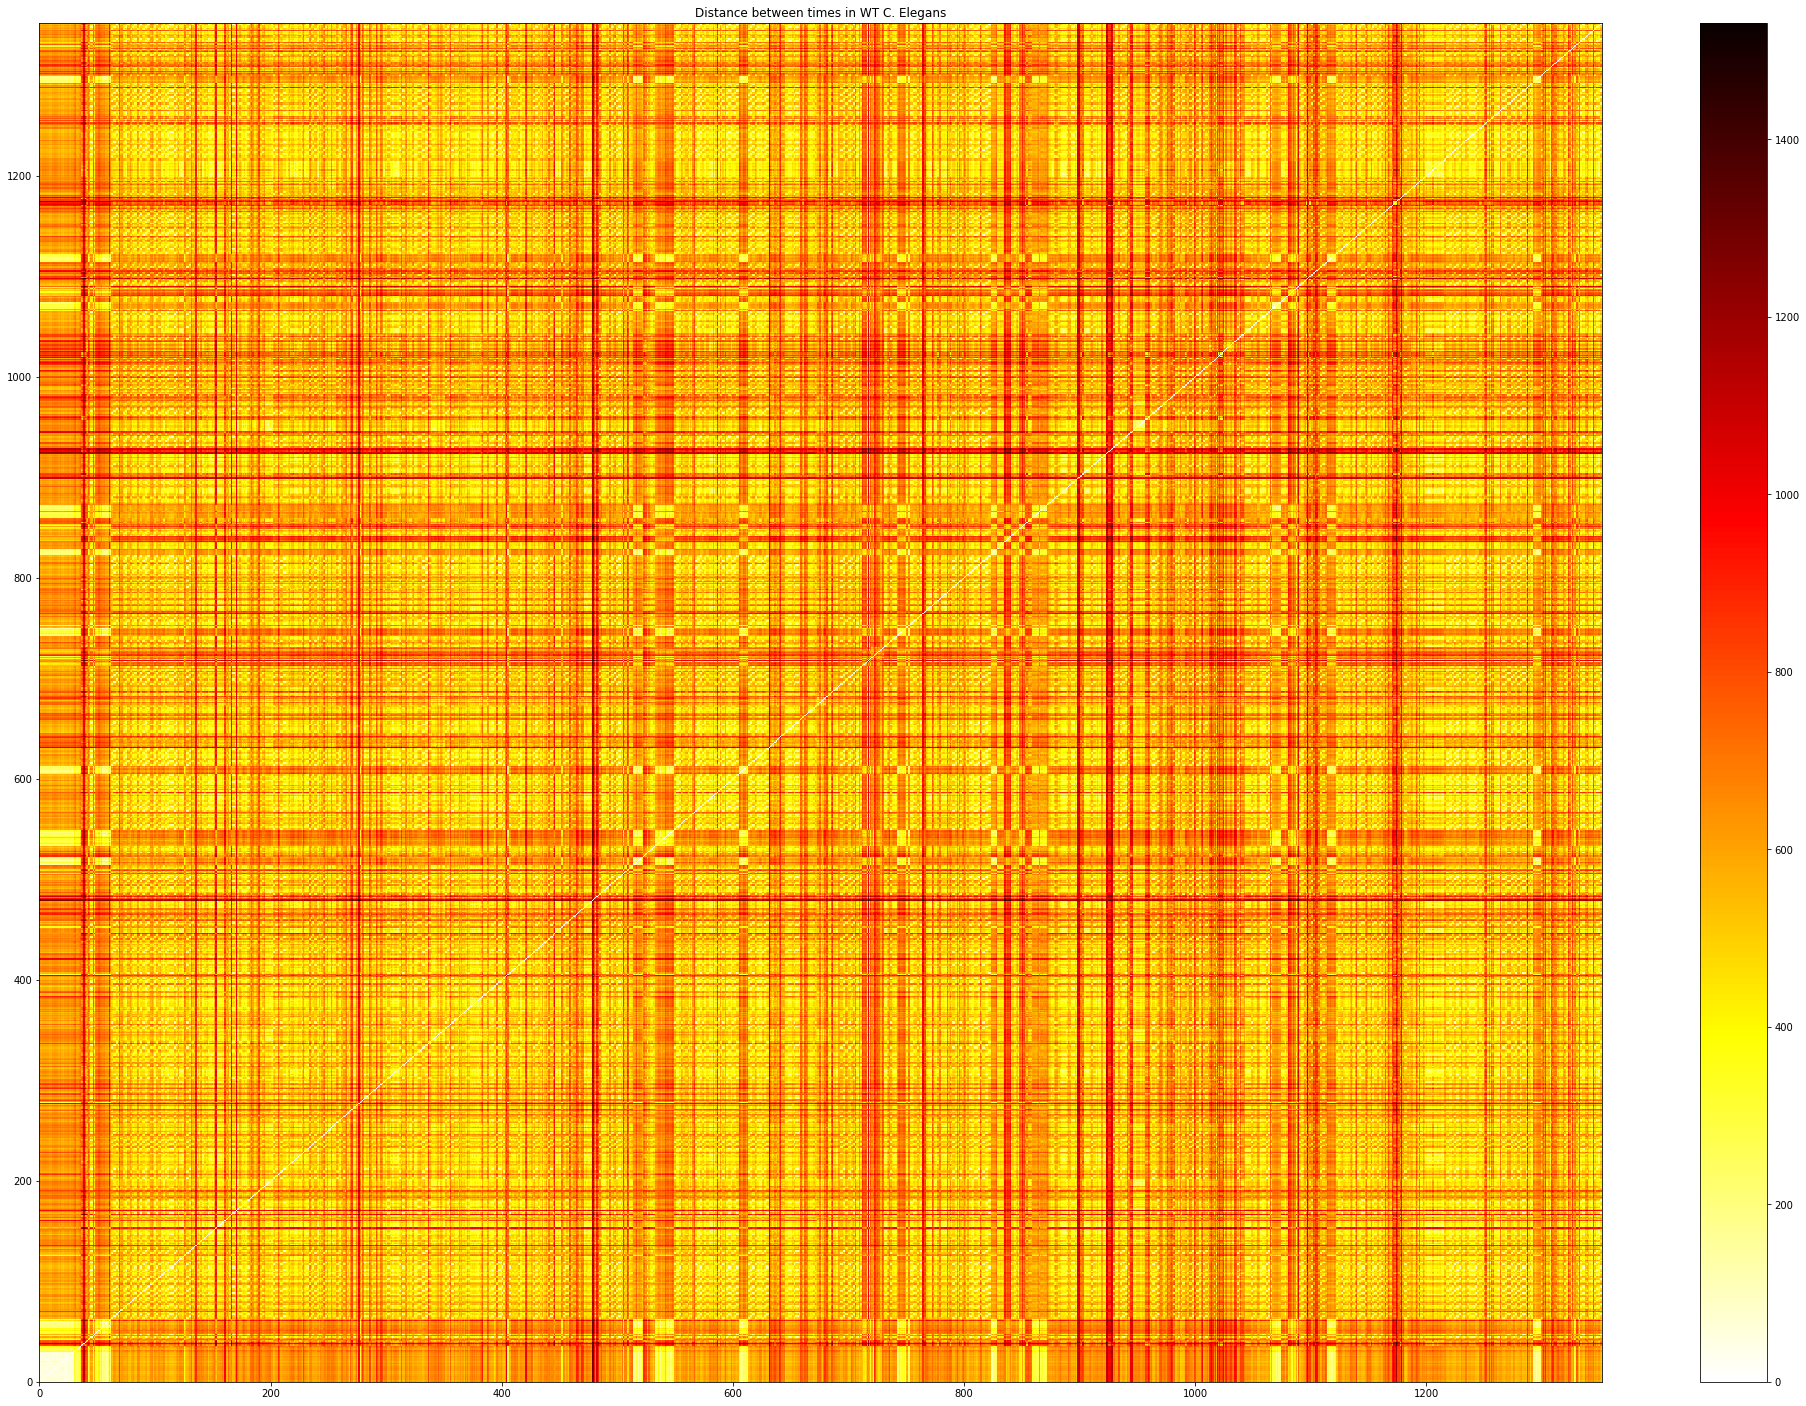

In [45]:
plot_2_examples(['hot_r'],(np.mat(full_WT_comp)))

(Supplemental Figure 1) Figure below

/tmp/ipykernel_389375/1043663754.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(np.mat(full_WT_comp), 'average')


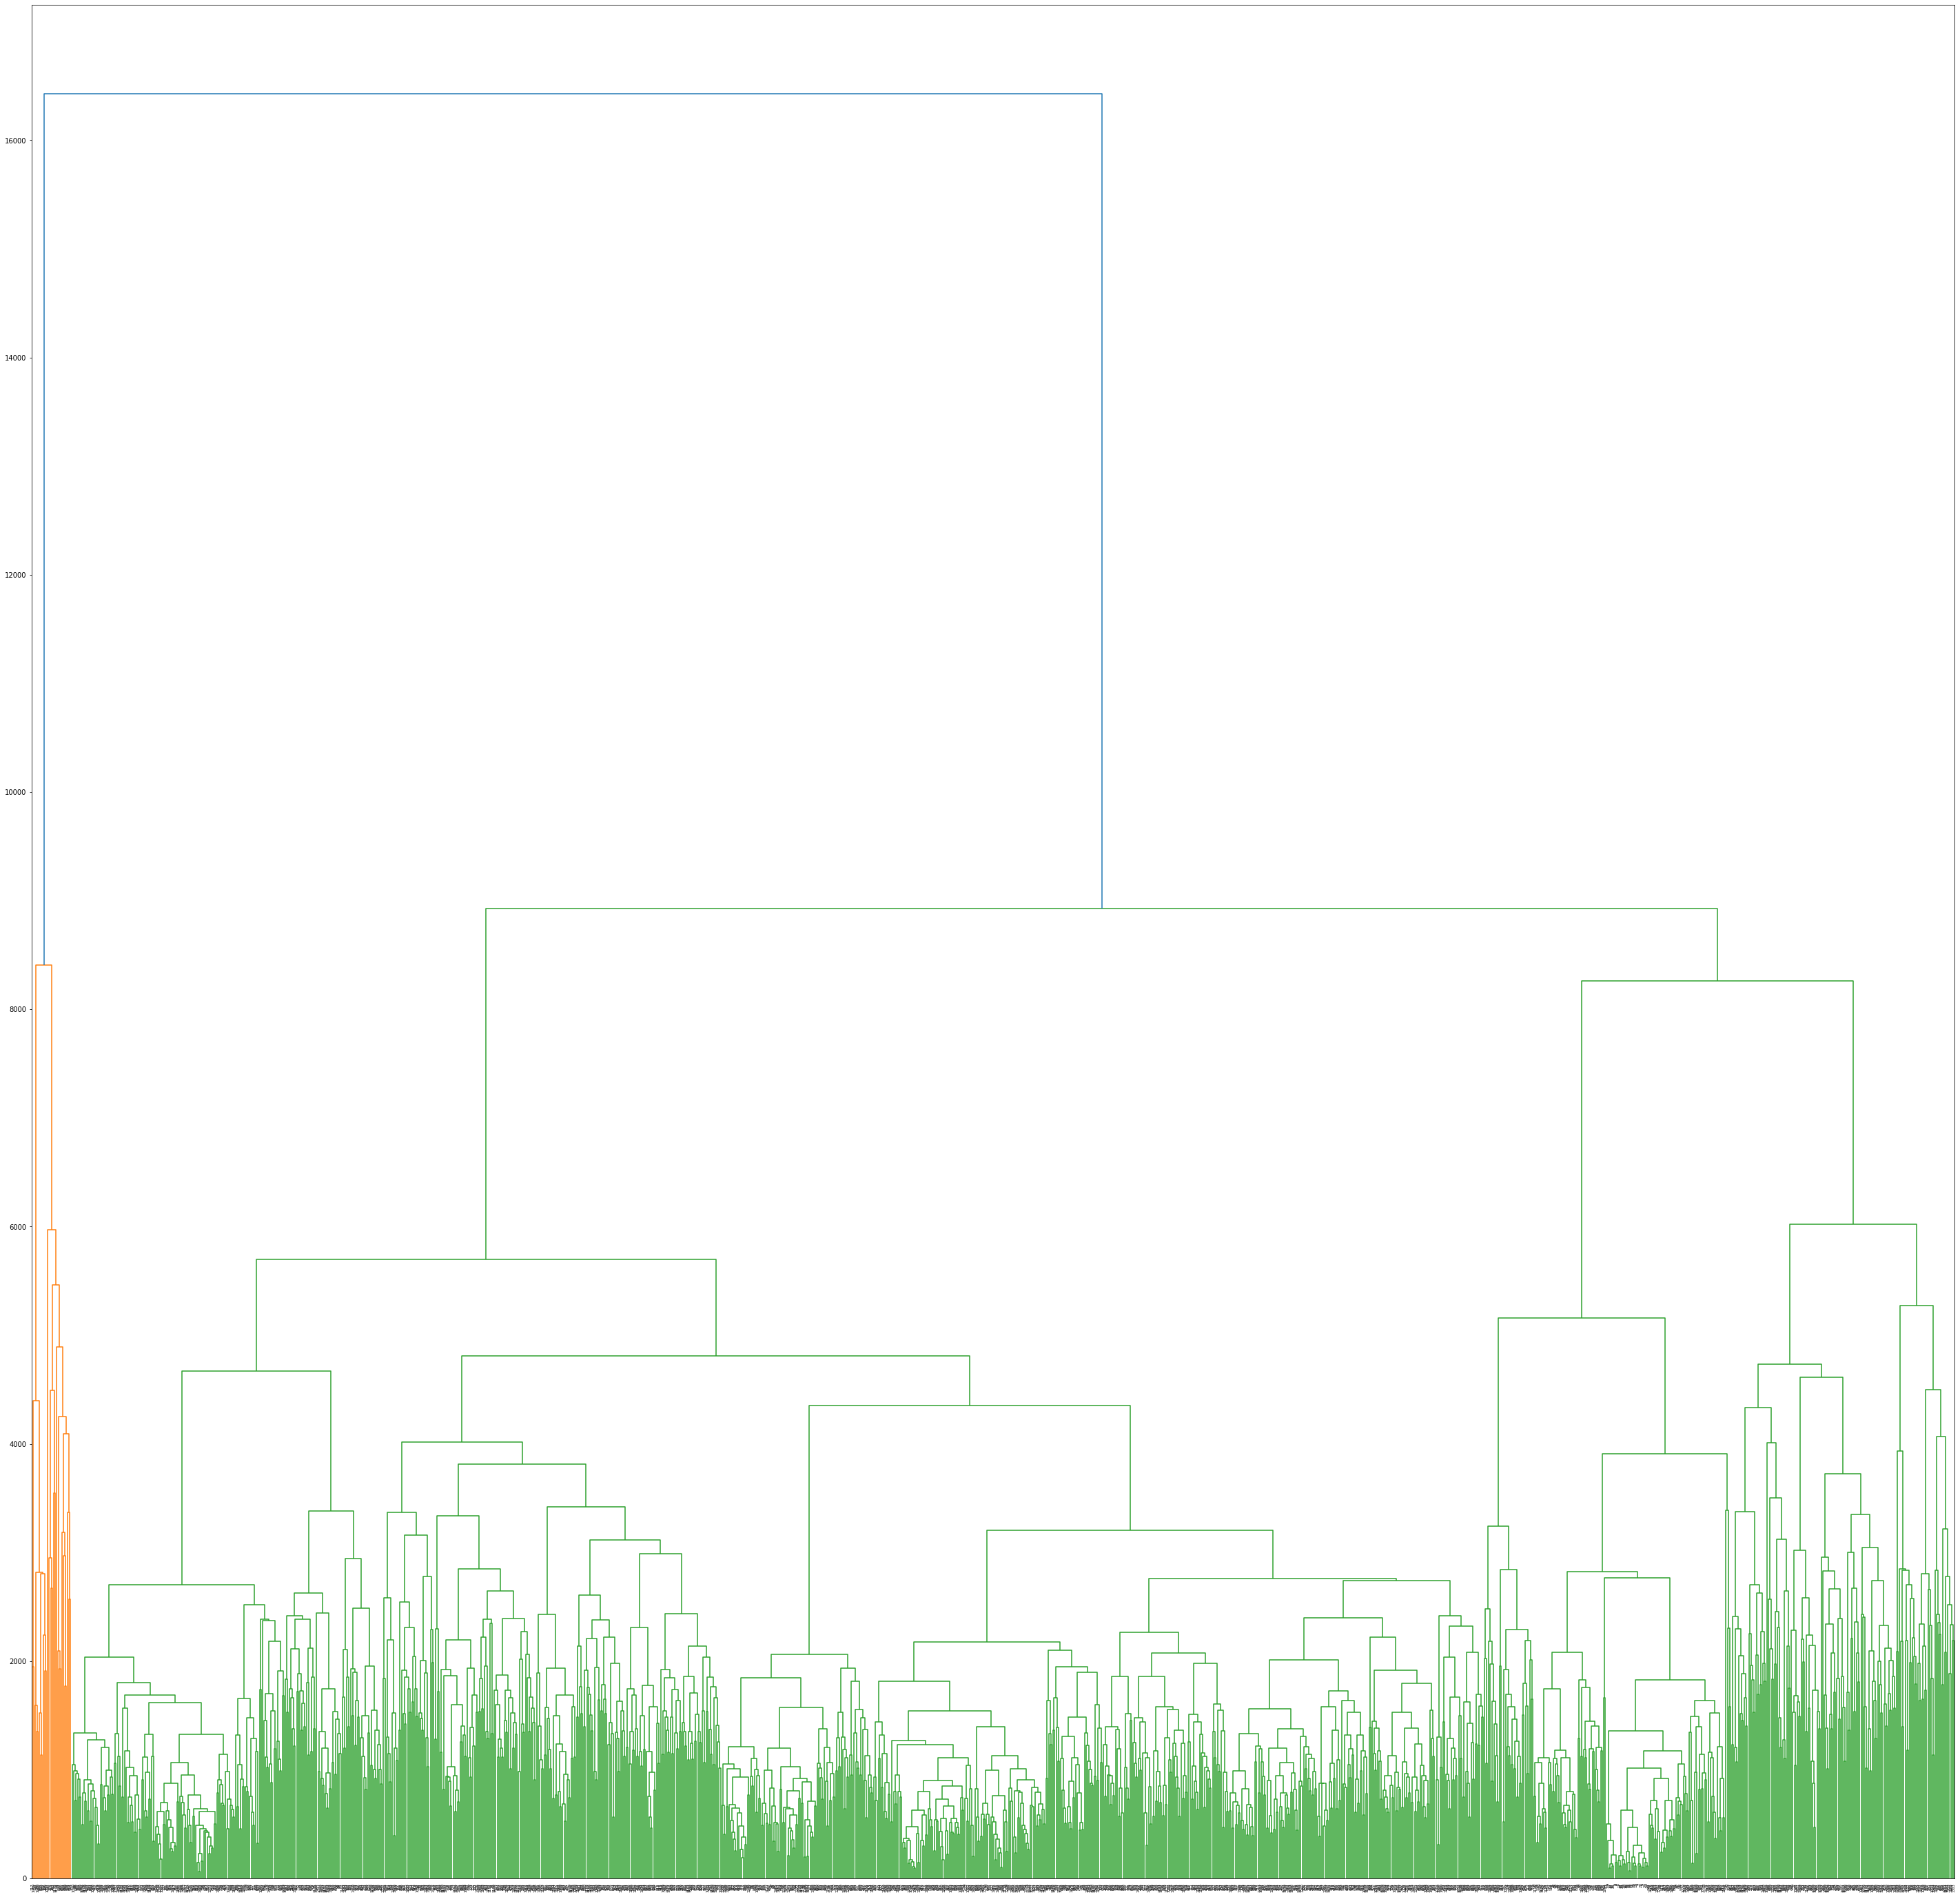

In [72]:
clust_count = 5
Z = linkage(np.mat(full_WT_comp), 'average')
fig = plt.figure(figsize=(50, 50))
dn = dendrogram(Z)
#fcluster(Z, t=6, criterion='maxclust') 
que = fcluster(Z, t=clust_count, criterion='maxclust') 

In [133]:
que2 = np.array(que)
que2[que2 == 1] = 2
oop = np.where(que2 == 1)[0].tolist()

for n in range(2,clust_count+1):
    oop = np.where(que2 == n)[0].tolist() + oop
oop = oop[::-1]

#oop = np.where(que == 1)[0].tolist() + np.where(que == 2)[0].tolist() + np.where(que == 3)[0].tolist() +np.where(que == 4)[0].tolist() + np.where(que == 5)[0].tolist()oop = np.where(que == 1)[0].tolist() + np.where(que == 2)[0].tolist() + np.where(que == 3)[0].tolist() +np.where(que == 4)[0].tolist() + np.where(que == 5)[0].tolist()

#oop = np.where(que == 1)[0].tolist() + np.where(que == 2)[0].tolist() + np.where(que == 4)[0].tolist() +np.where(que == 3)[0].tolist() + np.where(que == 4)[0].tolist()


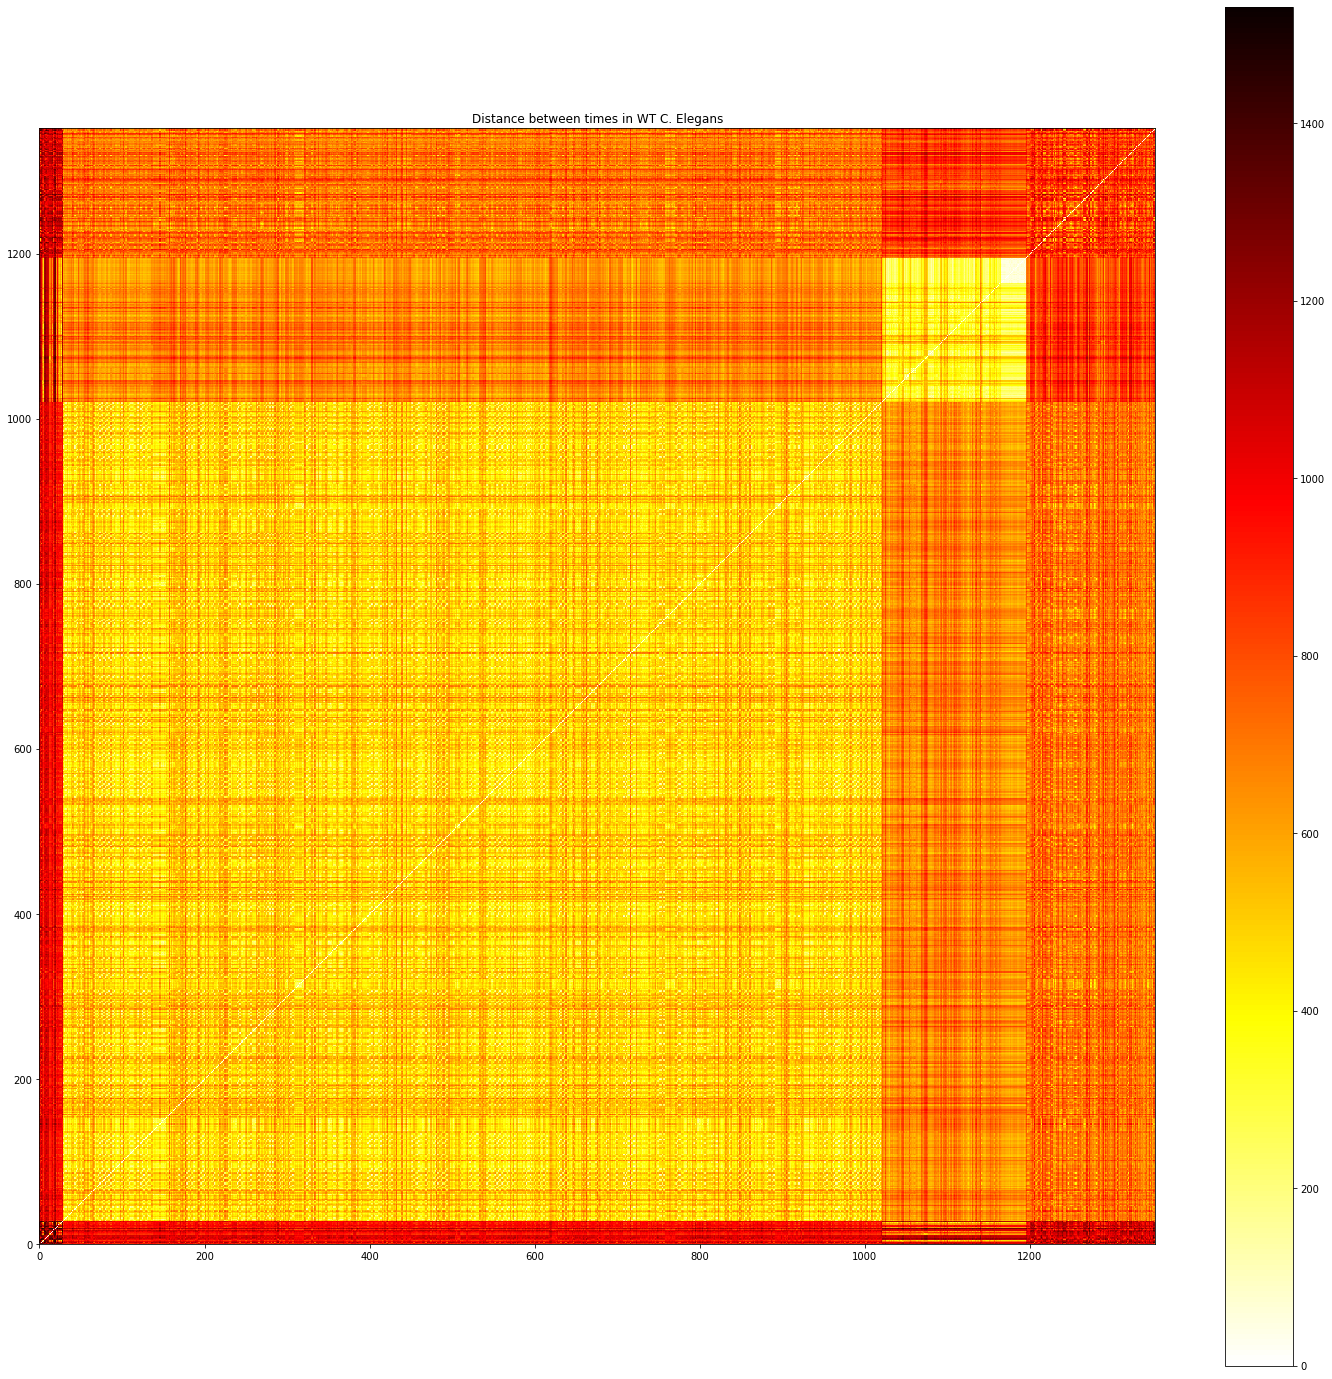

In [134]:
plot_2_examples(['hot_r'],full_WT_comp[oop].T[oop])

In [ ]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0))
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 25)
    plt.show()

In [75]:
full_BD_comp = []; full_TED_comp = []; full_PCA_comp = [];
for n in range(0,len(fulldictset)):
    temp_WT_comp = [] #; temp_r_comp = []
    temp_TED_comp = []
    for m in range(0,30):
        temp_WT_comp.append(intersection_branch_distance(fulldictset[n],fulldictset[m]))
        temp_TED_comp.append( tree_edit_distance(fulldictset[n],fulldictset[m]))
        #x,y = dict_to_vector(fulldictset[n],fulldictset[m])
        #m, b, r, p_value, std_err = stats.linregress(x,y)
        #temp_r_comp.append(r)
    full_BD_comp.append(temp_WT_comp)
    full_TED_comp.append(temp_TED_comp)
    #full_r_comp.append(temp_r_comp)
    #print(n)
full_BD_comp = np.mat(full_BD_comp)
full_TED_comp = np.mat(full_TED_comp)

In [ ]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=200) #200 TED, 275 BD instance
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (20,20))
    plt.gcf().set_size_inches(25, 10)
    #plt.gca().set_aspect('equal')
    #plt.rcParams['figure.figsize'] = [10, 10]
    plt.savefig("filepath.svg", format = 'svg', dpi=300)
    plt.show()

In [ ]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0))
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (20,20))
    plt.gcf().set_size_inches(25, 25)
    #plt.gca().set_aspect('equal')
    #plt.rcParams['figure.figsize'] = [10, 10]
    #plt.savefig("filepath.svg", format = 'svg', dpi=300)
    plt.show()

In [76]:
BD = full_BD_comp.T[inlier_ref]

In [78]:
TED = full_TED_comp.T[inlier_ref]

(Supplemental Figure 3) code below

In [84]:
df = pd.read_csv('functions.csv')

In [85]:
df = df.to_numpy()

In [86]:
functional_class_dict_00 = dict()
for n in set(df.T[2]):
    functional_class_dict_00[n] = []

In [87]:
for n in df:
    print(n[2],n[0])
    functional_class_dict_00[n[2]] = functional_class_dict_00[n[2]] + [n[0]]

cytoskeleton abi-1
general transcription ama-1
ubiquitin-like aos-1
signaling apr-1
signaling apx-1
cytoskeleton arx-2
RNA-binding/translation atx-2
cell cycle & cell division bub-1
unknown C01A2.5
general transcription C01F1.1
unknown C02B10.5
general transcription C06A5.1
mRNA Splicing C07A9.2
chromatin C08B11.3
cytoskeleton C49H3.8
mRNA Splicing C50F2.3
general transcription C55A6.9
unknown cacn-1
transcription factor camt-1
chromatin cbp-1
cell cycle & cell division cdc-25.1
protein folding and degredation cdc-37
multifunction cdk-7
general transcription cdk-9
DNA replication & repair cdt-1
transcription factor ceh-24
chromatin chaf-2
vesicles chc-1
DNA replication & repair chk-1
signaling cir-1
RNA processing clpf-1
cytoskeleton cls-2
signaling cmd-1
protein folding and degredation cpl-1
RNA processing cpsf-1
RNA processing cpsf-2
RNA processing cpsf-4
protein folding and degredation csn-4
ubiquitination cul-1
ubiquitination cul-2
ubiquitination cul-3
general transcription D1043.1

In [94]:
RNAi_size_assignments['SKR-1/2'] = RNAi_size_assignments['SKR-2']

In [ ]:
functional_class_dict_0 = dict()
for n in range(0,len(df)):
    q = df[n][0].upper()
    try:
        RNAi_size_assignments[q]
        print(q,df[n][2])
        gene_list.append(q); gene_list_function.append(df[n][2]); 
        try:
            functional_class_dict_0[df[n][2]] = functional_class_dict_0[df[n][2]] + [q]
        except:
            functional_class_dict_0[df[n][2]] = [q]
    except:
        pas

In [ ]:
functional_class_BD = dict(); functional_class_TED = dict(); gene_list = []; gene_list_function = []
print(list(functional_class_dict_0))

In [ ]:
for n in list(functional_class_dict_0):
    functional_class_BD[n] = []; functional_class_TED[n] = []
    print(n)

In [98]:
#for n in range(0,len(gene_list_function)): print(gene_list_function[n], gene_list[n])

In [99]:
gene_functional_assigment_dict = dict()
for n in range(0,len(df)):
    q = df[n][0].upper()
    #print(q,df[n][2])
    gene_functional_assigment_dict[q] = df[n][2]

In [ ]:
y0 = [];x0 = [];label0 = []

for n in list(functional_class_dict_0):
    print(n)
    functional_class_TED[n] =[]; functional_class_BD[n] = []
    for m in functional_class_dict_0[n]:
        #print(m,RNAi_size_assignments[m])
        #print(np.array(TED[0])[0][RNAi_size_assignments[m]],np.array(np.sum(BD, axis = 0)/22)[0][RNAi_size_assignments[m]])
        print(np.array(TED[0])[0][RNAi_size_assignments[m]].tolist(),np.array(np.sum(BD, axis = 0)/22)[0][RNAi_size_assignments[m]].tolist())
        functional_class_TED[n] = functional_class_TED[n] + np.array(TED[0])[0][RNAi_size_assignments[m]].tolist()
        functional_class_BD[n] = functional_class_BD[n] + np.array(np.sum(BD, axis = 0)/22)[0][RNAi_size_assignments[m]].tolist()
        #x0.append(np.sum(np.array(TED[0])[0][RNAi_size_assignments[m]]))
        #y0.append(np.sum(np.array(np.sum(BD, axis = 0)/22)[0][RNAi_size_assignments[m]]))

In [ ]:
y0 = [];x0 = [];label0 = []
for n in functional_class_TED:
    label0.append(n)
    #print(n,functional_class_TED[n],functional_class_BD[n])
    y0.append(sum(functional_class_BD[n])/len(functional_class_BD[n]))
    x0.append(sum(functional_class_TED[n])/len(functional_class_TED[n]))
    print(n,sum(functional_class_TED[n])/len(functional_class_TED[n]),sum(functional_class_BD[n])/len(functional_class_BD[n]))

In [ ]:
y0 = [];x0 = [];label0 = []
for n in functional_class_TED:
    label0.append(n)
    #print(n,functional_class_TED[n],functional_class_BD[n])
    y0.append(sum(functional_class_BD[n])/len(functional_class_BD[n]))
    x0.append(sum(functional_class_TED[n])/len(functional_class_TED[n]))
    print(n,min(functional_class_TED[n]),max(functional_class_TED[n]),min(functional_class_BD[n]),max(functional_class_BD[n]))

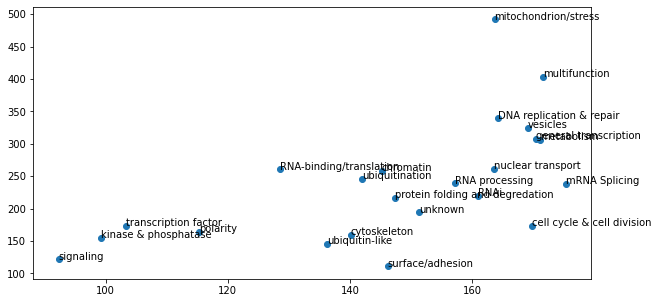

In [140]:
#(Supplemental Figure 3) Figure below
plt.scatter(x0,y0)

for i, txt in enumerate(label0):
    plt.annotate(txt, (x0[i], y0[i]))

In [106]:
y0 = [];x0 = [];label0 = []
for n in functional_class_TED:
    label0.append(n)
    #print(n,functional_class_TED[n],functional_class_BD[n])
    y0.append(sum(functional_class_BD[n])/len(functional_class_BD[n]))
    x0.append(sum(functional_class_TED[n])/len(functional_class_TED[n]))
    print(n,max(functional_class_TED[n]),min(functional_class_TED[n]),max(functional_class_BD[n]),max(functional_class_BD[n]))

cytoskeleton 247 14 526.4443614175333 526.4443614175333
general transcription 318 52 880.0626004772151 880.0626004772151
ubiquitin-like 194 20 304.1287370322412 304.1287370322412
signaling 243 6 357.68259453399554 357.68259453399554
RNA-binding/translation 210 14 804.995136472358 804.995136472358
cell cycle & cell division 232 126 703.8387449921028 703.8387449921028
unknown 216 100 640.5765383246639 640.5765383246639
mRNA Splicing 258 44 774.2696449143419 774.2696449143419
chromatin 254 8 1096.9322410773907 1096.9322410773907
transcription factor 204 6 563.7666120994853 563.7666120994853
protein folding and degredation 187 56 525.8918016035984 525.8918016035984
multifunction 233 128 785.5216769333397 785.5216769333397
DNA replication & repair 264 118 716.4638880179903 716.4638880179903
vesicles 296 121 1023.045250562007 1023.045250562007
RNA processing 206 22 422.5937985196246 422.5937985196246
ubiquitination 268 8 642.2648844826767 642.2648844826767
RNAi 192 112 315.36361998469096 315

In [137]:
scatter_RNAi_list = []
for n in functional_class_dict_00:
    #print(n, functional_class_dict_00[n])
    scatter_RNAi_list = scatter_RNAi_list + functional_class_dict_00[n]

In [138]:
scatter_RNAi_color = []
colorvar = 0
for n in functional_class_dict_00:
    #print(n, functional_class_dict_00[n])
    scatter_RNAi_color = scatter_RNAi_color + [list(mcolors.CSS4_COLORS.values())[colorvar]] * len(functional_class_dict_00[n])
    colorvar = colorvar + 1

In [139]:
scatter_RNAi_color = ['b'] + scatter_RNAi_color

In [114]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0)) #200 TED, 275 BD instance
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (20,20))
    plt.gcf().set_size_inches(25, 25)
    plt.gca().set_aspect('equal')
    #plt.rcParams['figure.figsize'] = [30, 30]
    plt.savefig("filepath.svg", format = 'svg', dpi=300)
    plt.show()

In [115]:
group = []
for n in set(que):
    #print(n, np.where(que == n)[0].tolist())
    group = group + np.where(que == n)[0].tolist()

In [ ]:
functional_class_dict_reverse = dict()
for n in functional_class_dict_00:
    #print(n, )
    for m in functional_class_dict_00[n]:
        #print(m.upper(),n)
        functional_class_dict_reverse[m.upper()] = n

In [119]:
functional_class_dict_inverse = dict()
for n in functional_class_dict_reverse:
    try:
        functional_class_dict_inverse[functional_class_dict_reverse[n]].append(n)
    except:
        functional_class_dict_inverse[functional_class_dict_reverse[n]] = [n]
    #print(n,functional_class_dict_reverse[n])
#functional_class_dict_reverse
#functional_class_dict_inverse

In [123]:
functional_class_dict_count = dict()
for n in functional_class_dict_inverse:
    mcounts = 0
    for m in functional_class_dict_inverse[n]:
        #print(n,m)
        mcounts = mcounts + len(RNAi_size_assignments[m])
    #print(n,mcounts)
    functional_class_dict_count[n] = mcounts

In [1]:
functional_class_dict_assignment = dict()

In [127]:
from scipy.stats import fisher_exact
table = [[28,116],[54,1124]]
res = fisher_exact(table)
res

(5.0242656449553005, 4.108878450487851e-09)

In [128]:
import scipy.stats as stats

table = [[30,144],[0,1322]]
res = stats.boschloo_exact(table, alternative="greater")

res.pvalue

1.7531027004668835e-30

In [135]:
#que2 = np.array(que)
#que2[que2 == 1] = 2

In [ ]:
functional_class_dict_assignment = dict()
bonfcounter = 0
for n in set(que2):
    temp_list_ = []
    for m in np.where(que2 == n)[0].tolist():
        #print(n,m, RNAi_name_array[m])
        try:
            #print(functional_class_dict_reverse[RNAi_name_array[m]])
            temp_list_.append(functional_class_dict_reverse[RNAi_name_array[m]])
        except:
            #print(n,m, RNAi_name_array[m])
            pass
    #print(n,temp_list_)
    print('\ncluster',n - 1)
    print("functional classification,  Enrichment Analysis P-value")
    for k in set(temp_list_):
        bonfcounter = bonfcounter + 1
        A,B = temp_list_.count(k), len(np.where(que2 == n)[0]) - temp_list_.count(k)
        if n == 4: B = B - 30
        C = functional_class_dict_count[k] - temp_list_.count(k)
        D = len(RNAi_name_array) - 30 - A - B - C
        table = [[A,B],[C,D]]
        #res = fisher_exact(table)
        res = stats.boschloo_exact(table, alternative="greater")
        print(k, res.pvalue)
        #functional_class_dict_assignment[(n,k)] = res[1]
        

In [141]:
bonfcounter

65

In [142]:
functional_class_dict_assignment = dict()
bonfcounter = 0
for n in set(que2):
    temp_list_ = []
    for m in np.where(que2 == n)[0].tolist():
        #print(n,m, RNAi_name_array[m])
        try:
            #print(functional_class_dict_reverse[RNAi_name_array[m]])
            temp_list_.append(functional_class_dict_reverse[RNAi_name_array[m]])
        except:
            #print(n,m, RNAi_name_array[m])
            pass
    #print(n,temp_list_)
    print('cluster',n - 1)
    print('functional classification, Enrichment Analysis p-value')
    for k in set(temp_list_):
        bonfcounter = bonfcounter + 1
        A,B = temp_list_.count(k), len(np.where(que2 == n)[0]) - temp_list_.count(k)
        if n == 4: B = B - 30
        C = functional_class_dict_count[k] - temp_list_.count(k)
        D = len(RNAi_name_array) - 30 - A - B - C
        table = [[A,B],[C,D]]
        #res = fisher_exact(table)
        res = stats.boschloo_exact(table, alternative="greater")
        if res.pvalue < 0.01 / 65:
            print(k,res.pvalue)
        #functional_class_dict_assignment[(n,k)] = res[1]
    print('\n')
        

cluster 1
functional classification, Enrichment Analysis p-value


cluster 2
functional classification, Enrichment Analysis p-value
unknown 4.227310114987746e-05


cluster 3
functional classification, Enrichment Analysis p-value
signaling 5.730327492131708e-16
polarity 0.00014881243435759678
transcription factor 2.256015062893801e-09
kinase & phosphatase 1.7689513428071435e-08


cluster 4
functional classification, Enrichment Analysis p-value
DNA replication & repair 0.00011744538665523696
mitochondrion/stress 1.4298812359206831e-05




In [ ]:
bonfcounter = 0
for n in set(que2):
    Gene_tracker = RNAi_name_array[np.where(que2 == n)]
    #print(n,)
    print('\nCluster', n-1)
    print('Gene, Number of Embryos in Cluster, Enrichment Analysis P-value')
    for m in sorted(set(Gene_tracker)):
        A,B =  np.sum(Gene_tracker == m), np.max(np.shape(np.where(que2 == n))) - np.sum(Gene_tracker == m)
        #print( np.sum(Gene_tracker == m), np.max(np.shape(np.where(que2 == n))) - np.sum(Gene_tracker == m))
        try:
            bonfcounter = bonfcounter + 1
            C = len(RNAi_size_assignments[m]) - A
            if n == 4: B = B - 30
            D = len(RNAi_name_array) - 30 - A - B - C
            #print(A,B)
            #print(C,D)
            table = [[A,B],[C,D]]
            #res = fisher_exact(table)
            
            res = stats.boschloo_exact(table, alternative="greater")
            if 'WT' not in m:
                print(m,',', np.sum(m == Gene_tracker),',', res.pvalue)
                #print(m)
            #print()
        except:
            pass
        #C,D = RNAi_size_assignments(m)
    #set()

In [ ]:
RNAi_name_array[que2 == 4]

In [ ]:
parts = set(que2)
for n in sorted(set(RNAi_name_array)):
    print(n)
    for m in parts:
        Gene_tracker = np.sum(RNAi_name_array[que2 == m] == n)
        if Gene_tracker > 0:
            print('cluster ',m - 1,":", Gene_tracker, 'embryos')

In [ ]:
len(que2), sum(que2 == 4)

In [144]:
#bonfcounter = 0
for n in set(que2):
    Gene_tracker = RNAi_name_array[np.where(que2 == n)]
    print("Cluster ",n -1)
    print('gene, enrichment analysis p value\n')
    for m in sorted(set(Gene_tracker)):
        #print(n,m)
        A,B =  np.sum(Gene_tracker == m), np.max(np.shape(np.where(que2 == n))) - np.sum(Gene_tracker == m)
        #print( np.sum(Gene_tracker == m), np.max(np.shape(np.where(que2 == n))) - np.sum(Gene_tracker == m))
        try:
            #bonfcounter = bonfcounter + 1
            C = len(RNAi_size_assignments[m]) - A
            if n == 4: B = B - 30
            D = len(RNAi_name_array) - 30 - A - B - C
            #print(A,B)
            #print(C,D)
            table = [[A,B],[C,D]]
            res = stats.boschloo_exact(table, alternative="greater")
            if res.pvalue < 0.01 / 302 and 'WT' not in m:
                print(m,res.pvalue)
                #print(m)
            #print()
        except:
            pass
        #C,D = RNAi_size_assignments(m)
    #set()
    print('\n')

Cluster  1
gene, enrichment analysis p value

RAB-5 1.1376947255712227e-06


Cluster  2
gene, enrichment analysis p value



Cluster  3
gene, enrichment analysis p value

ABI-1 7.414136894932323e-07
APR-1 7.414136894932323e-07
APX-1 5.631090298447121e-07
GLP-1 6.954789377585454e-09
GSK-3 5.464721903023907e-11
HDA-1 7.414136894932323e-07
LAG-1 6.954789377585454e-09
MOM-2 6.954789377585454e-09
PAL-1 7.414136894932323e-07
PIE-1 7.414136894932323e-07
POP-1 7.414136894932323e-07
SKN-1 7.184788364905302e-08
SKR-2 7.553613890544976e-06
SRC-1 6.954789377585454e-09
WWP-1 7.184788364905302e-08


Cluster  4
gene, enrichment analysis p value

RFC-3 1.2302969701929437e-07
RPB-11 1.286501543850782e-06
SPN-4 1.286501543850782e-06




In [ ]:
'''ABI-1 P,
APR-1 P,
APX-1 HT,TT
GLP-1 HT,TT
GSK-3 P,HT,TT
HDA-1 P,HT
LAG-1 HT,TT
MOM-2 P,HT,TT
PAL-1 P
PIE-1 P,HT,TT
POP-1 P,HT,TT
SKN-1 HT,TT
SKR-2 P,HT
SRC-1 P,HT 
WWP-1 HT,TT'''

In [ ]:
bagman = 0
average_branch_distances = []
bogo = set(RNAi_name_array)
#bogo = set(scatter_RNAi_list)
bogo.remove('inlierWT');bogo.remove('outlierWT')

q = 30

indy = np.mat(full_WT_comp)[range(0,30)].T[range(0,30)]

shortround = indy[np.triu_indices(q)].flatten()

data2 =  shortround[shortround != 0].tolist()
#plt.scatter([bagman] * len(data2), data2, c = 'g')

#print(np.triu_indices(len(q[0])))

average_branch_distances.append(np.mean(data2))

plt.scatter(bagman, np.mean(data2), c = 'g')

plt.errorbar(bagman, np.mean(data2), yerr=[[np.min(data2)],[np.max(data2)]], fmt='o')  



bagman = bagman + 1

for nn in bogo:
    n = nn.upper()
    q = np.where(RNAi_name_array == n)
    #print(q)
    indy = np.mat(full_WT_comp)[q].T[q]
    #short = np.shape(indy)[0]
    #print(short)
    #print(indy.T[np.triu_indices(short,-1)])
    #print(indy[np.where(0 == np.triu(indy))],"\n")
    shortround = indy[np.triu_indices(len(q[0]))].flatten()
    #print()
    data2 =  shortround[shortround != 0].tolist()[0] 
    #print(n,np.mean(data), np.var(data))
    #plt.scatter([bagman] * len(data2), data2, c = "b")
    plt.scatter(bagman, np.mean(data2), c = "r")
    
    #print(len(data2))
    
    if len(data2) == 0: 
        
        data2 = [0]
        print("GOGOG",n)
    
    plt.errorbar(bagman, np.mean(data2), yerr=[[np.min(data2)],[np.max(data2)]], fmt='o'  )
    average_branch_distances.append(np.mean(data2))
    
    #sns.swarmplot(data2)
    #print(len(q[0]))
    #print(np.triu_indices(short,-1))
    bagman = bagman + 1
    
#plt.xticks(range(0,bagman),["WT"] + list(bogo)) 
plt.xticks(range(0,bagman),["WT"] + list(bogo)) 

In [155]:
#(Supplemental Figure 2) code below

In [148]:
from scipy.stats import norm
x_d_0 = np.linspace(0, 1100, 10000)
x = [np.array(average_branch_distances)[0]]
#x_d_0 = np.linspace(0, 1100, 10000)average_branch_distances = average_branch_distances[average_branch_distances > 0]
density_0 = sum(norm(x[xi], np.sqrt(average_branch_distances[xi])).pdf(x_d_0) for xi in range(len(x)))

In [ ]:

x = average_branch_distances[1:]
x_d = np.linspace(0, 1200, 12000)
x_d = x_d_0
density = sum(norm(xi, 7).pdf(x_d) for xi in x)

plt.fill_between(range(len(x_d)), density_0, color='red', alpha=.1)

In [ ]:
x = [average_branch_distances[0]]
x_d_0 = np.linspace(0, 1100, 1000)
density_0 = sum(norm(xi, 7).pdf(x_d_0) for xi in x)
x = average_branch_distances[1:]
x_d = np.linspace(0, 1100, 1000)
density = sum(norm(xi, 7).pdf(x_d) for xi in x)

#plt.plot(density)
plt.fill_between(range(len(x_d)), density, color='blue', alpha=.1)
#plt.plot(range(len(x_d)), density)
#plt.fill_between(range(len(x_d)), density_0, color='red', alpha=.1)
#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
#plt.plot(np.where(x_d == x), np.full_like(x, -0.1))
#plt.xticks(x_d)
#plt.fill_between(np.linspace(-4, 800, 10000) ,density, alpha=0.5)
#plt.savefig("heterogeneity.svg", format = "svg")

In [ ]:
bagman = 0
average_branch_distances = []
average_branch_variances = []
bogo = set(RNAi_name_array)
#bogo = set(scatter_RNAi_list)
bogo.remove('inlierWT');bogo.remove('outlierWT')

q = 30

indy = np.mat(full_WT_comp)[range(0,30)].T[range(0,30)]

shortround = indy[np.triu_indices(q)].flatten()

data2 =  shortround[shortround != 0].tolist()
#plt.scatter([bagman] * len(data2), data2, c = 'g')

#print(np.triu_indices(len(q[0])))

average_branch_distances.append(np.mean(data2))
average_branch_variances.append(np.var(data2))

plt.scatter(bagman, np.mean(data2), c = 'g')

plt.errorbar(bagman, np.mean(data2), yerr=[[np.min(data2)],[np.max(data2)]], fmt='o')  



bagman = bagman + 1

for nn in bogo:
    n = nn.upper()
    q = np.where(RNAi_name_array == n)
    #print(q)
    indy = np.mat(full_WT_comp)[q].T[q]
    #short = np.shape(indy)[0]
    #print(short)
    #print(indy.T[np.triu_indices(short,-1)])
    #print(indy[np.where(0 == np.triu(indy))],"\n")
    shortround = indy[np.triu_indices(len(q[0]))].flatten()
    #print()
    data2 =  shortround[shortround != 0].tolist()[0] 
    #print(n,np.mean(data), np.var(data))
    #plt.scatter([bagman] * len(data2), data2, c = "b")
    plt.scatter(bagman, np.mean(data2), c = "r")
    
    #print(len(data2))
    
    if len(data2) == 0: 
        
        data2 = [0]
        print("GOGOG",n)
    
    plt.errorbar(bagman, np.mean(data2), yerr=[[np.min(data2)],[np.max(data2)]], fmt='o'  )
    average_branch_distances.append(np.mean(data2))
    average_branch_variances.append(np.var(data2))
    
    #sns.swarmplot(data2)
    #print(len(q[0]))
    #print(np.triu_indices(short,-1))
    bagman = bagman + 1
    
#plt.xticks(range(0,bagman),["WT"] + list(bogo)) 
plt.xticks(range(0,bagman),["WT"] + list(bogo)) 

In [152]:
scatter_RNAi_list_group = []
for n in functional_class_dict_00:
    scatter_RNAi_list_group = scatter_RNAi_list_group + [n] * len(functional_class_dict_00[n])
    #print()
    

(Supplemental Figure 2A) Figure below

GOGOG PAR-5
GOGOG PKC-3


([<matplotlib.axis.XTick at 0x7f0c40463310>,
 [Text(0, 0, 'WT'),
  Text(1, 0, 'DNA replication & repair'),
  Text(2, 0, 'DNA replication & repair'),
  Text(3, 0, 'DNA replication & repair'),
  Text(4, 0, 'DNA replication & repair'),
  Text(5, 0, 'DNA replication & repair'),
  Text(6, 0, 'DNA replication & repair'),
  Text(7, 0, 'DNA replication & repair'),
  Text(8, 0, 'DNA replication & repair'),
  Text(9, 0, 'DNA replication & repair'),
  Text(10, 0, 'DNA replication & repair'),
  Text(11, 0, 'DNA replication & repair'),
  Text(12, 0, 'DNA replication & repair'),
  Text(13, 0, 'signaling'),
  Text(14, 0, 'signaling'),
  Text(15, 0, 'signaling'),
  Text(16, 0, 'signaling'),
  Text(17, 0, 'signaling'),
  Text(18, 0, 'signaling'),
  Text(19, 0, 'signaling'),
  Text(20, 0, 'signaling'),
  Text(21, 0, 'signaling'),
  Text(22, 0, 'signaling'),
  Text(23, 0, 'signaling'),
  Text(24, 0, 'signaling'),
  Text(25, 0, 'cell cycle & cell division'),
  Text(26, 0, 'cell cycle & cell division'),
  

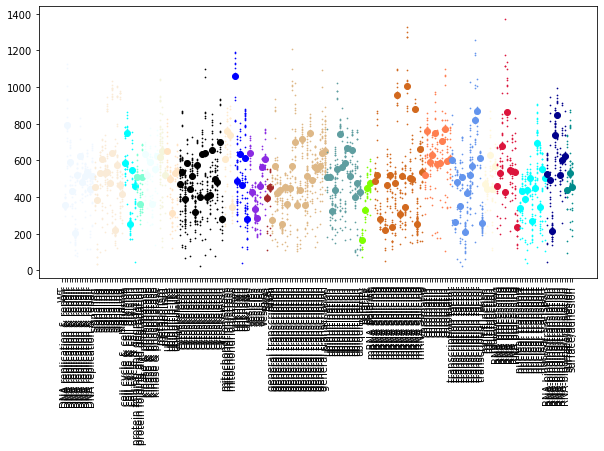

In [153]:
bagman = 0
average_branch_distances = []
average_branch_distances_WT = []
bogo = sorted(set(RNAi_name_array))
#bogo = set(scatter_RNAi_list)
bogo.remove('inlierWT');bogo.remove('outlierWT')

x_d_0 = np.linspace(0, 1100, 10000)

q = 30

indy = np.mat(full_WT_comp)[range(0,30)].T[range(0,30)]

shortround = indy[np.triu_indices(q)].flatten()

data2 =  shortround[shortround != 0].tolist()
#plt.scatter([bagman] * len(data2), data2, c = 'g')

#print(np.triu_indices(len(q[0])))

#average_branch_distances.append(np.mean(data2))
#average_branch_variances.append(np.var(data2))

average_branch_distances_WT = data2

#plt.scatter(bagman, np.median(data2), c = 'g')

#plt.errorbar(bagman, np.median(data2), yerr=[[np.min(data2)],[np.max(data2)]], fmt='o')  



bagman = bagman + 1

for nn in bogo:
    n = nn.upper()
    q = np.where(RNAi_name_array == n)
    #print(q)
    indy = np.mat(full_WT_comp)[q].T[q]
    #short = np.shape(indy)[0]
    #print(short)
    #print(indy.T[np.triu_indices(short,-1)])
    #print(indy[np.where(0 == np.triu(indy))],"\n")
    shortround = indy[np.triu_indices(len(q[0]))].flatten()
    #print()
    data2 =  shortround[shortround != 0].tolist()[0] 
    #print(n,np.mean(data), np.var(data))
    plt.scatter([bagman] * len(data2), data2, c = scatter_RNAi_color[bagman], s = 0.5)
    plt.scatter(bagman, np.median(data2), c = scatter_RNAi_color[bagman])
    #plt.scatter(bagman, data2, c = scatter_RNAi_color[bagman] * len(data2))
    
    #print(len(data2))
    
    if len(data2) == 0: 
        
        data2 = [0]
        print("GOGOG",n)
    
    #plt.errorbar(bagman, np.median(data2), yerr=[[np.min(data2)],[np.max(data2)]], fmt='o' ,c = scatter_RNAi_color[bagman] )
    average_branch_distances = average_branch_distances + data2
    #average_branch_variances.append(np.var(data2))
    
    #sns.swarmplot(data2)
    #print(len(q[0]))
    #print(np.triu_indices(short,-1))
    bagman = bagman + 1
    
#plt.xticks(range(0,bagman),["WT"] + list(bogo)) 
plt.xticks(range(0,bagman),["WT"] + scatter_RNAi_list_group, rotation = 90) 






(Supplemental Figure 2B) Figure below

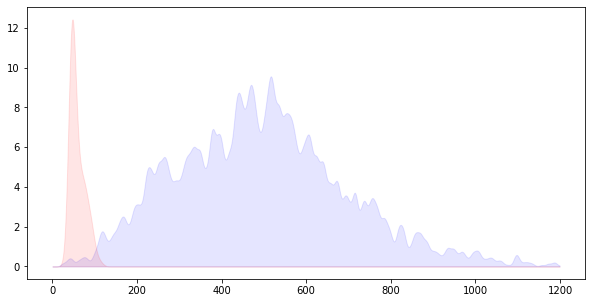

In [154]:
average_branch_distances = np.array(average_branch_distances)
average_branch_distances = average_branch_distances[average_branch_distances > 0]

average_branch_variances = np.array(average_branch_variances)
average_branch_variances = average_branch_variances[average_branch_variances > 0]



x_d_0 = np.linspace(0, 1200, 1200)
x = average_branch_distances_WT[0]
#x_d_0 = np.linspace(0, 1200, 12000)
density_0 = sum(norm(xi, 7).pdf(x_d_0) for xi in x)


x = average_branch_distances[1:]
x_d = np.linspace(0, 1200, 1200)
x_d = x_d_0
density = sum(norm(xi, 6).pdf(x_d) for xi in x)

#plt.plot(density)
plt.fill_between(range(len(x_d)), density, color='blue', alpha=.1)

#plt.plot(average_branch_distances, np.full_like(average_branch_distances, -0.1), '|k', markeredgewidth=1)
#plt.plot(range(len(x_d)), density)
plt.fill_between(range(len(x_d)), density_0, color='red', alpha=.1)
#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
#plt.plot(np.where(x_d == x), np.full_like(x, -0.1))
#plt.xticks(x_d)
#plt.fill_between(np.linspace(-4, 800, 10000) ,density, alpha=0.5)

#plt.plot(average_branch_distances_WT, np.full_like(average_branch_distances_WT, -0.1), '|k', markeredgewidth=1)
#plt.savefig("heterogeneity.svg", format = "svg")

plt.savefig("SFig_2B.svg", format = "svg")

(Supplemental Figure 4) Code below

In [ ]:
inlier_ref

In [ ]:
self_b_mat_RNAi = [];
inlier_ref = [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 18, 21, 22, 23, 24, 25, 27, 28, 29]

self_b_mat_RNAi_eff = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))
for n in range(0,len(root_cells_comp)):
    for m in range(0,len(inlier_ref)):
        x_index = n*len(inlier_ref)+m
        nim = node_comparison_trimmer(fulldictset[inlier_ref[m]],root_cells_comp[n])
        for a in range(0,len(root_cells_comp)):
            for b in range(0,len(inlier_ref)):
                y_index = a*len(inlier_ref)+b
                if y_index > x_index:
                    continue
                ab = node_comparison_trimmer(fulldictset[inlier_ref[b]],root_cells_comp[a])
                self_b_mat_RNAi_eff[x_index,y_index] = union_branch_distance(nim,ab)
        #self_b_mat_RNAi.append(branches)
    print(root_cells_comp[n])
self_b_mat_RNAi_eff = self_b_mat_RNAi_eff + self_b_mat_RNAi_eff.T

In [ ]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0)) #200 TED, 275 BD instance
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (20,20))
    plt.gcf().set_size_inches(25, 25)
    plt.gca().set_aspect('equal')
    #plt.rcParams['figure.figsize'] = [30, 30]
    plt.savefig("filepath.svg", format = 'svg', dpi=300)
    plt.show()

(Supplemental Figure 4) Figure below

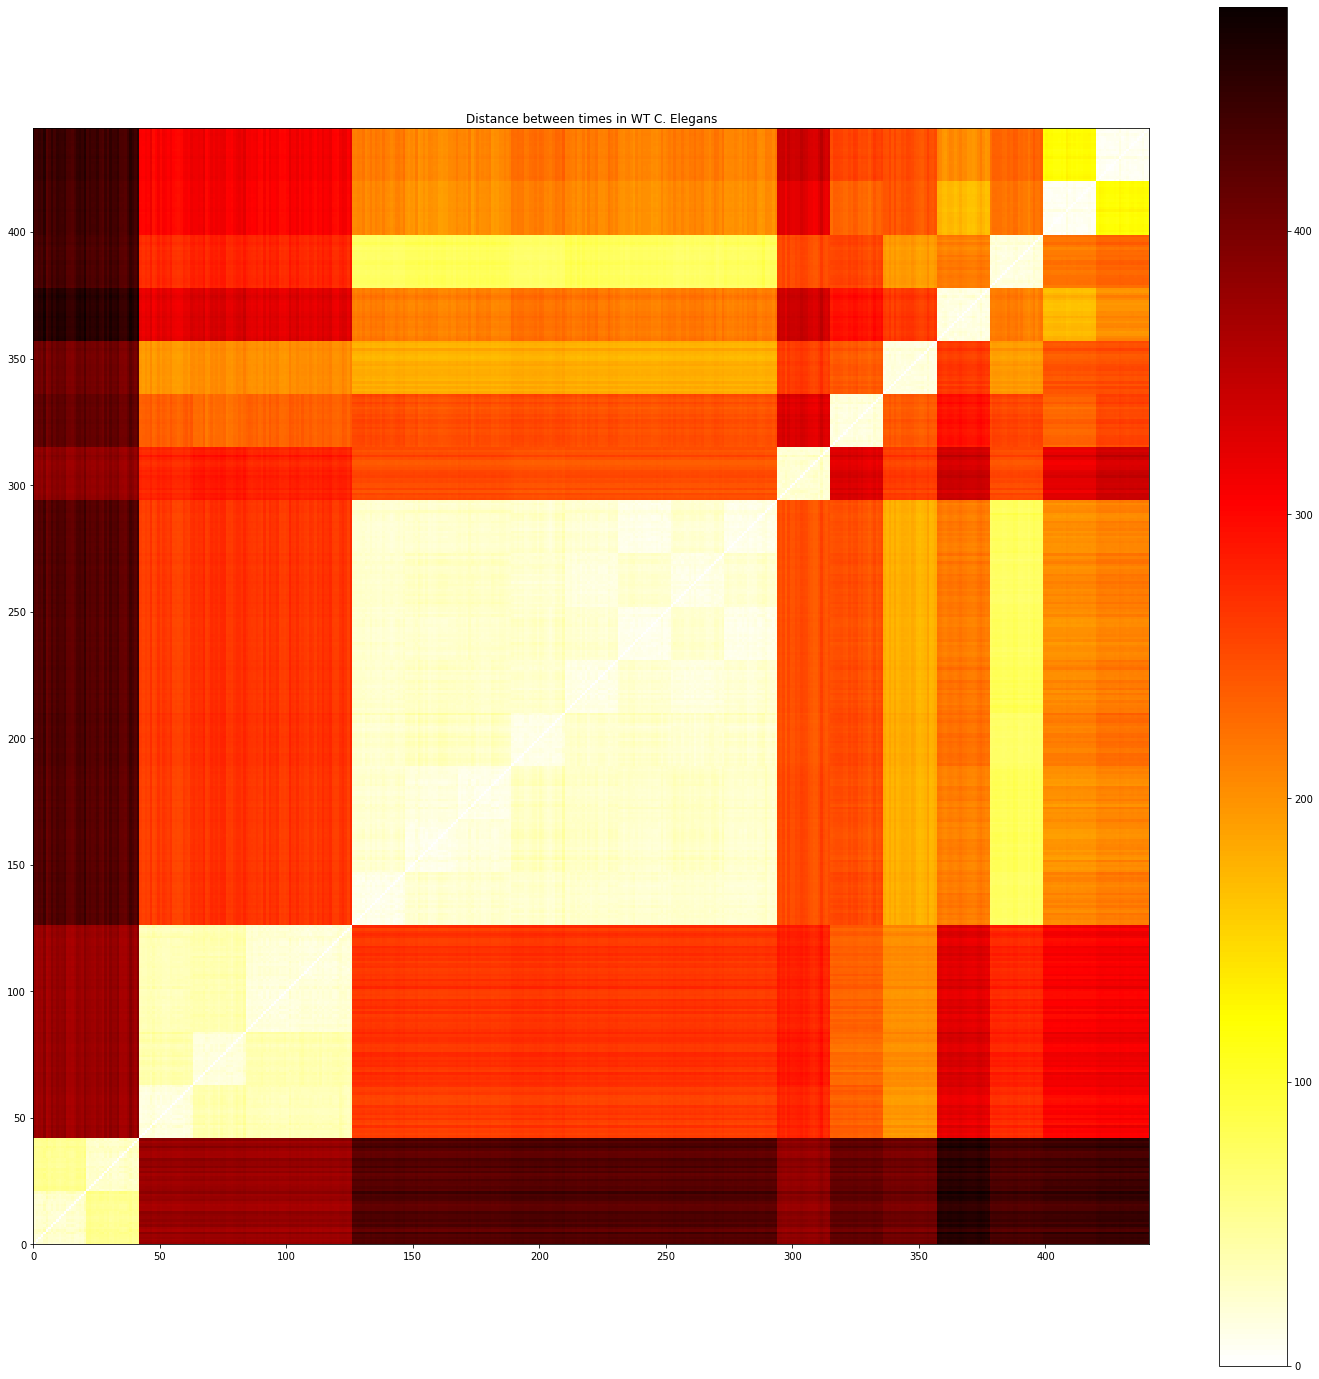

0.0 478.91152627599183


In [158]:
b_mat = self_b_mat_RNAi_eff
plot_2_examples(['hot_r'],self_b_mat_RNAi_eff)
print(min(self_b_mat_RNAi_eff.flatten()),max(self_b_mat_RNAi_eff.flatten()))

In [ ]:
(Supplemental Figure 4B) code below

In [ ]:
scale = len(inlier_ref);b_mat = np.mat(b_mat)
resample_mat = [];ttest_mat = [];bm_mat = []
for n in range(0,scale-1):
    resample_row = [];ttest_row = [];bm_row = []
    nn = self_comp(np.mat(b_mat[n*scale:(n+1)*scale,n*scale:(n+1)*scale])).tolist()
    for m in range(0,scale-1):
        go2 = np.mat(b_mat[n*scale:(n+1)*scale,m*scale:(m+1)*scale]).flatten()[0]
        go2 = go2[go2 != 0]
        mm = go2.tolist()[0]
        ntsp = novel_two_sample_permutation_test(nn,mm,500)
        if ntsp > 0.01:
            if n != m:
                print('WT/WT branch',root_cells_comp[n],'WT/WT branch',root_cells_comp[n],root_cells_comp[m])
            #print(ntsp)
        resample_row.append(ntsp)
        #t,p = ttest_ind(nn,mm, equal_var=False)
        #ttest_row.append(p)
        #t2,p2 = stats.brunnermunzel(nn,mm)
        #bm_row.append(p2)
    #print(n)
    resample_mat.append(resample_row)
    #ttest_mat.append(ttest_row)
    #bm_mat.append(bm_row)

resample_mat = np.mat(resample_mat);#ttest_mat = np.mat(ttest_mat);bm_mat = np.mat(bm_mat)
bm_mat = np.nan_to_num(bm_mat)

(Supplemental Figure 5) Figure below

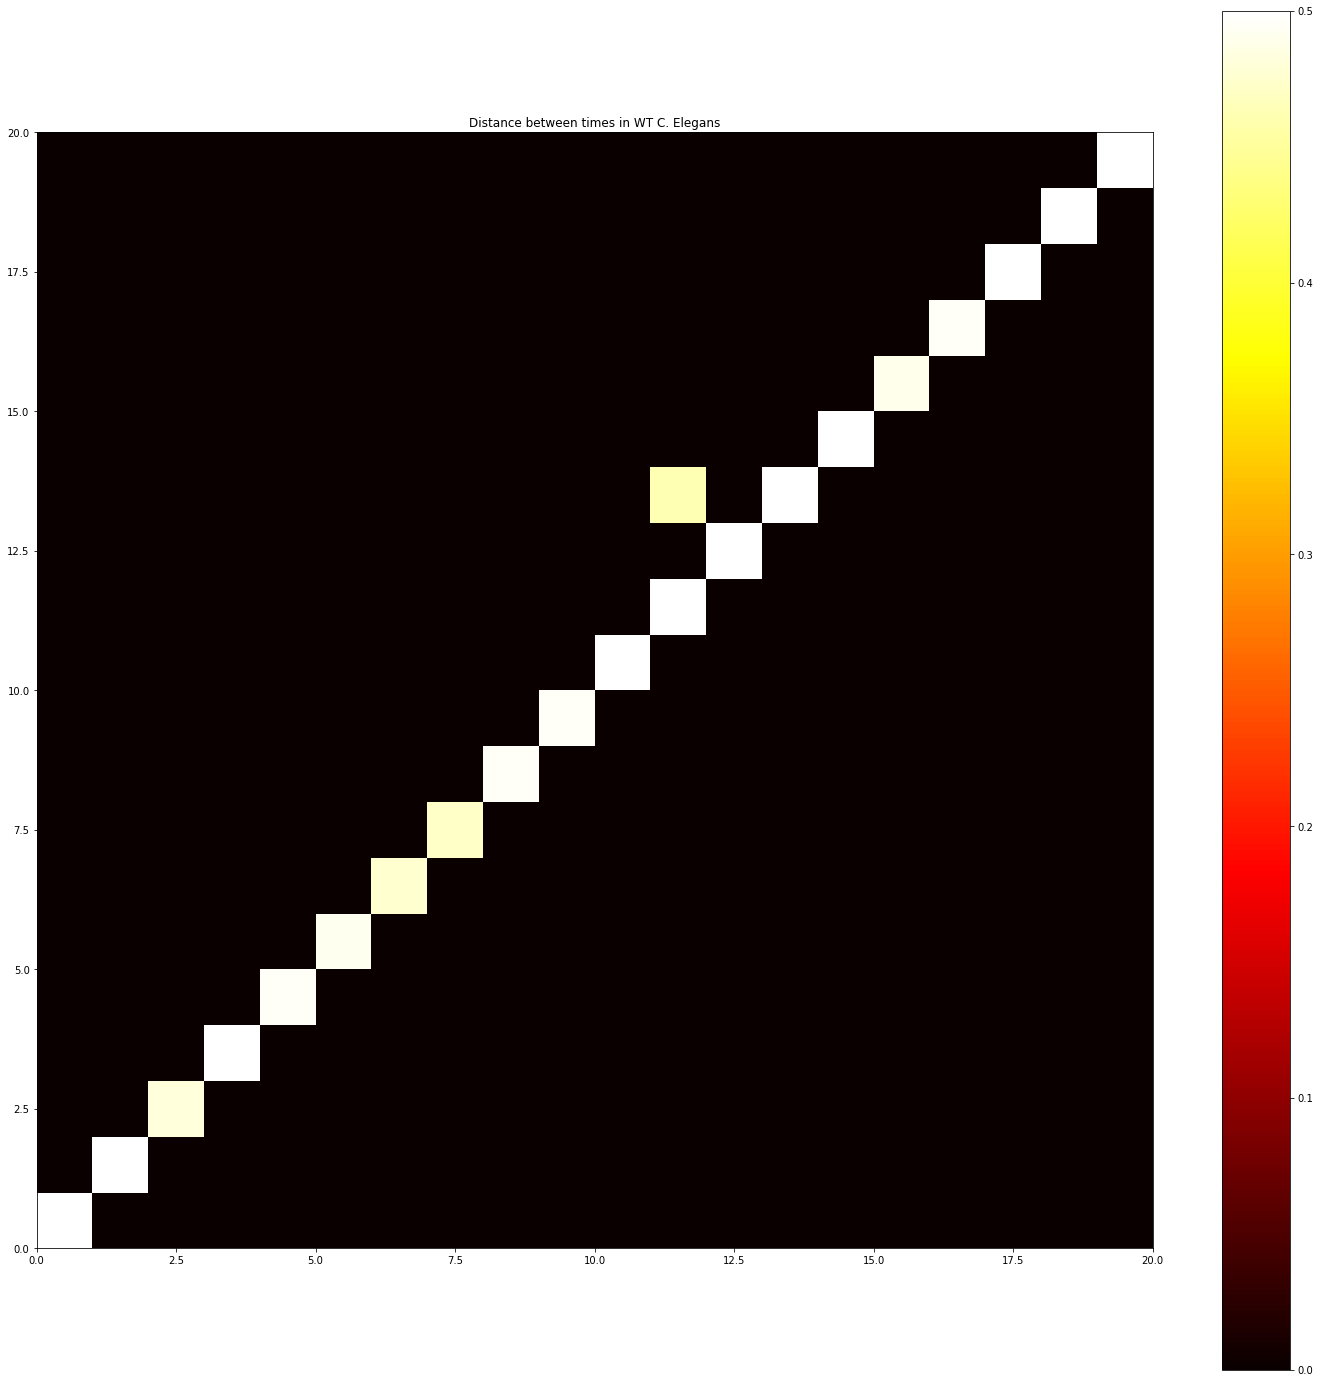

In [161]:
plot_2_examples(['hot'],resample_mat) #rerun the code with more iterations to get the result shown in the paper.
#replace 500 with whichever one you prefer

In [162]:
def dict_PCA_list(x,y):
    xaxis = [];yaxis = []
    for n in (list(set(x).intersection(set(y)))):
        xaxis.append(x[n]);yaxis.append(y[n]) 
    points = np.array([xaxis,yaxis]).T; pca = PCA(n_components=2); pca.fit(points)
    eigenvectors = pca.components_; eigenvalues = pca.explained_variance_;
    return eigenvectors[0][1]/eigenvectors[0][0]

dict_PCA_list(fulldictset[1],fulldictset[10])

1.007726250146163

In [163]:
(Supplemental Figure 6) Code below

SyntaxError: invalid syntax (1125628705.py, line 1)

In [164]:
def dict_counter(x,y):
    Xc=0;Yc=0
    for n in (list(set(x).intersection(set(y)))):
        #print(x[n], y[n])
        if x[n] > y[n]: 
            Xc = Xc + 1
            #print(n)
        elif x[n] < y[n]: 
            Yc = Yc + 1
    #print(Xc,Yc)
    return Xc,Yc
        #print(n,lis[x][n],lis[y][n])

dict_counter(node_comparison_trimmer(fulldictset[inlier_ref[0]],root_cells_comp[n]),node_comparison_trimmer(fulldictset[inlier_ref[0]],root_cells_comp[m]))

(0, 0)

In [166]:
inlier_ref = [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 18, 21, 22, 23, 24, 25, 27, 28, 29]

In [ ]:
self_b_mat_RNAi = [];
#inlier_ref = [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 18, 21, 22, 23, 24, 25, 27, 28, 29];

self_b_mat_RNAi_eff = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))
self_b_mat_RNAi_opp = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))
self_b_mat_RNAi_slope = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))
for n in range(0,len(root_cells_comp)):
    for m in range(0,len(inlier_ref)):
        x_index = n*len(inlier_ref)+m
        nim = node_comparison_trimmer(fulldictset[inlier_ref[m]],root_cells_comp[n])
        nim_list = list(nim.values())
        for a in range(0,len(root_cells_comp)):
            for b in range(0,len(inlier_ref)):
                y_index = a*len(inlier_ref)+b
                #if y_index > x_index:
                #    continue
                ab = node_comparison_trimmer(fulldictset[inlier_ref[b]],root_cells_comp[a])
                QQ = dict_counter(nim,ab)
                print(QQ)
                self_b_mat_RNAi_slope[x_index,y_index] = dict_PCA_list(nim,ab)
                try:
                    self_b_mat_RNAi_eff[x_index,y_index] = QQ[1]
                    #self_b_mat_RNAi_opp[x_index,y_index] = QQ[0]
                except:
                    self_b_mat_RNAi_eff[x_index,y_index] = 1
                #self_b_mat_RNAi_eff[x_index,y_index] = union_branch_distance(nim,ab)
        #self_b_mat_RNAi.append(branches)
    print(root_cells_comp[n])
#self_b_mat_RNAi_eff = self_b_mat_RNAi_eff + self_b_mat_RNAi_eff.T

In [3]:
#plot_2_examples(['PuOr'],self_b_mat_RNAi_eff[6*len(inlier_ref):14*len(inlier_ref)].T[6*len(inlier_ref):14*len(inlier_ref)])

In [ ]:



def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0)) #200 TED, 275 BD instance
        fig.colorbar(psm, ax=ax)
    #plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (20,20))
    plt.gcf().set_size_inches(25, 25)
    plt.gca().set_aspect('equal')
    #plt.rcParams['figure.figsize'] = [30, 30]
    plt.savefig("filepath.svg", format = 'svg', dpi=300)
    #plt.show()

In [5]:

self_b_mat_RNAi = [];
inlier_ref = [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 18, 21, 22, 23, 24, 25, 27, 28, 29];

self_b_mat_RNAi_eff = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))
self_b_mat_RNAi_opp = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))
self_b_mat_RNAi_slope = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))
for n in range(0,len(root_cells_comp)):
    for m in range(0,len(inlier_ref)):
        x_index = n*len(inlier_ref)+m
        nim = node_comparison_trimmer(fulldictset[inlier_ref[m]],root_cells_comp[n])
        nim_list = list(nim.values())
        for a in range(0,len(root_cells_comp)):
            for b in range(0,len(inlier_ref)):
                y_index = a*len(inlier_ref)+b
                #if y_index > x_index:
                #    continue
                ab = node_comparison_trimmer(fulldictset[inlier_ref[b]],root_cells_comp[a])
                QQ = dict_counter(nim,ab)
                print(QQ)
                self_b_mat_RNAi_slope[x_index,y_index] = dict_PCA_list(nim,ab)
                try:
                    self_b_mat_RNAi_eff[x_index,y_index] = QQ[1]
                    #self_b_mat_RNAi_opp[x_index,y_index] = QQ[0]
                except:
                    self_b_mat_RNAi_eff[x_index,y_index] = 1
                #self_b_mat_RNAi_eff[x_index,y_index] = union_branch_distance(nim,ab)
        #self_b_mat_RNAi.append(branches)
    print(root_cells_comp[n])
#self_b_mat_RNAi_eff = self_b_mat_RNAi_eff + self_b_mat_RNAi_eff.T 

'\nself_b_mat_RNAi = [];\ninlier_ref = [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 18, 21, 22, 23, 24, 25, 27, 28, 29];\n\nself_b_mat_RNAi_eff = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))\nself_b_mat_RNAi_opp = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))\nself_b_mat_RNAi_slope = np.zeros((len(inlier_ref)*len(root_cells_comp),len(inlier_ref)*len(root_cells_comp)))\nfor n in range(0,len(root_cells_comp)):\n    for m in range(0,len(inlier_ref)):\n        x_index = n*len(inlier_ref)+m\n        nim = node_comparison_trimmer(fulldictset[inlier_ref[m]],root_cells_comp[n])\n        nim_list = list(nim.values())\n        for a in range(0,len(root_cells_comp)):\n            for b in range(0,len(inlier_ref)):\n                y_index = a*len(inlier_ref)+b\n                #if y_index > x_index:\n                #    continue\n                ab = node_comparison_trimmer(fulldictset[inlier_ref[b]],root_cells_com

(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(14, 1)
(14, 1)
(14, 1)
(15, 0)
(15, 0)
(15, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(15, 0)


(14, 0)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(14, 1)
(13, 0)
(12, 2)
(12, 2)
(12, 1)
(13, 0)
(13, 0)
(13, 0)
(13, 0)
(13, 0)
(14, 0)
(13, 0)
(13, 1)
(13, 0)
(13, 0)
(14, 0)
(14, 0)
(14, 0)
(13, 1)
(14, 0)
(13, 0)
(13, 0)
(14, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)

(14, 1)
(14, 0)
(14, 1)
(14, 1)
(15, 0)
(15, 0)
(14, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 1)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 1)
(7, 0)
(7, 0)
(3, 3)
(1, 5)
(3, 3)
(2, 3)
(3, 3)
(3, 4)
(3, 4)
(3, 4)
(4, 3)
(1, 6)
(1, 5)
(2, 4)
(5, 1)
(3, 2)
(3, 4)
(3, 4)
(3, 2)
(1, 5)
(1, 5)
(2, 5)
(3, 4)
(2, 5)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15,

(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(14, 1)
(14, 1)
(14, 1)
(15, 0)
(15, 0)
(15, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(14, 0)
(14, 1)
(14, 1)
(15, 0)
(15, 0)
(15, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(14, 0)
(14, 1)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(14, 1)
(14, 1)
(14, 1)
(15, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(14, 0)
(14, 1)
(15, 0)
(15, 0)
(15, 0)
(14, 0)


(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(14, 0)
(13, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(15, 0)
(14, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(8, 5)
(8, 6)
(8, 4)
(9, 5)
(9, 4)
(10, 5)
(12, 3)
(11, 4)
(11, 4)
(8, 5)
(11, 3)
(14, 2)
(14, 1)
(13, 3)
(14, 1)
(12, 4)
(13, 1)
(10, 4)
(0, 0)
(8, 6)
(11, 3

(14, 0)
(14, 1)
(14, 1)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(15, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 1)
(14, 0)
(14, 1)
(14, 1)
(15, 0)
(15, 0)
(14, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 0)
(7, 0)
(7, 0)
(5, 1)
(1, 6)
(4, 3)
(4, 3)
(3, 2)
(4, 2)
(3, 1)
(2, 3)
(5, 1)
(1, 5)
(2, 3)
(3, 3)
(6, 1)
(4, 3)
(3, 4)
(2, 2)
(4, 2)
(3, 3)
(2, 4)
(2, 5)
(4, 3)
(3, 3)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(14, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15, 0)
(15,

(1, 14)
(1, 14)
(1, 14)
(1, 14)
(1, 14)
(1, 14)
(1, 14)
(1, 14)
(1, 14)
(1, 14)
(1, 14)
(1, 14)
(0, 14)
(1, 14)
(1, 14)
(1, 14)
(22, 4)
(0, 0)
(14, 11)
(12, 9)
(18, 9)
(23, 4)
(21, 5)
(18, 9)
(17, 5)
(14, 8)
(14, 9)
(24, 3)
(27, 0)
(19, 4)
(22, 4)
(19, 4)
(24, 1)
(14, 6)
(14, 11)
(12, 7)
(19, 5)
(17, 11)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(0, 7)
(1, 5)
(2, 5)
(2, 5)
(1, 5)
(2, 5)
(2, 5)
(2, 5)
(1, 5)
(1, 5)
(2, 5)
(2, 5)
(2, 5)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(2

(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(20, 7)
(20, 6)
(18, 7)
(21, 7)
(17, 8)
(25, 3)
(21, 4)
(18, 8)
(23, 3)
(19, 5)
(20, 5)
(23, 4)
(24, 2)
(19, 7)
(23, 4)
(22, 4)
(25, 2)
(21, 5)
(17, 9)
(17, 8)
(23, 3)
(19, 6)
(22, 5)
(20, 8)
(19, 8)
(18, 8)
(17, 9)
(22, 4)
(24, 4)
(20, 5)
(23, 4)
(20, 4)
(20, 4)
(24, 4)
(25, 3)
(22, 5)
(22, 3)
(24, 3)
(23, 3)
(23, 5)
(19, 7)
(18, 8)
(20, 3)
(21, 5)
(22, 5)
(19, 7)
(19, 7)
(21, 7)
(20, 6)
(24, 3)
(24, 3)
(22, 5)
(23, 3)
(24, 3)
(21, 4)
(23, 4)
(24, 4)
(24, 4)
(24, 4)
(21, 4)
(26, 3)
(22, 5)
(21, 6)
(20, 5)
(21, 4)
(23, 4)
(19, 9)
(18, 10)
(18, 9)

(15, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(14, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(14, 1)
(10, 5)
(11, 3)
(12, 2)
(10, 2)
(11, 3)
(11, 3)
(12, 1)
(13, 2)
(11, 3)
(11, 4)
(13, 0)
(14, 0)
(15, 0)
(12, 2)
(12, 3)
(13, 2)
(11, 3)
(11, 3)
(11, 4)
(11, 4)
(10, 4)
(29, 0)
(28, 1)
(27, 0)
(27, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(0, 14)
(0, 15)
(0, 15)
(0, 15)
(0, 14)
(0, 14)
(1, 14)
(0, 14)
(1, 14)
(1, 14)
(0, 14)
(1, 14)
(1, 14)
(1, 14)
(1, 14)
(0, 14)
(1, 14)
(0, 14)
(0, 15)
(1, 14)
(1, 14)
(1, 14)
(16, 8)
(5, 21)
(3, 22)
(4, 21)
(7, 14)
(9, 10)
(0, 0)
(11, 12)
(13, 10)
(5, 19)
(7, 18)
(15, 7)
(20, 0)
(15, 10)
(12, 11)
(9, 14)
(16, 6)
(8, 14)
(5, 19)
(10, 15)
(13, 13)
(6, 19)
(2, 5)
(1, 5)
(1, 6)
(1, 6)
(2, 5)
(2, 5)
(1, 5)
(1, 6)
(1, 5)
(0, 7)
(1, 6)
(1, 5)
(2, 5)
(1, 6)
(1, 5)
(1, 5)
(2, 5)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(1, 6)
(0, 7)
(0, 

(2, 5)
(1, 6)
(1, 6)
(1, 5)
(2, 5)
(2, 5)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29,

(29, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(28, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(18, 7)
(18, 9)
(19, 8)
(19, 9)
(17, 9)
(21, 5)
(20, 7)
(17, 10)
(21, 5)
(20, 7)
(19, 8)
(18, 7)
(20, 5)
(18, 8)
(20, 6)
(20, 8)
(21, 5)
(19, 8)
(19, 9)
(19, 9)
(19, 5)
(20, 7)
(20, 7)
(20, 9)
(20, 8)
(21, 8)
(16, 12)
(20, 7)
(19, 6)
(19, 9)
(22, 5)
(20, 6)
(19, 6)
(21, 6)
(21, 4)
(21, 5)
(21, 6)
(21, 5)
(21, 5)
(21, 5)
(19, 10)
(20, 8)
(20, 7)
(20, 8)
(21, 6)
(21, 8)
(20, 9)
(20, 7)
(19, 9)
(22, 5)
(21, 6)
(21, 6)
(22, 5)
(22, 5)
(20, 7)
(20, 5)
(22, 4)
(21, 4)
(21, 6)
(21, 6)
(21, 5)
(21, 7)
(21, 7)
(20, 7)
(21, 7)
(20, 7)
(17, 9)
(14, 11)
(17, 12)
(14, 10)
(13, 11)
(19, 9)
(19, 7)
(16, 10)
(15, 10)
(18, 10)
(16, 9)
(15, 10)
(19, 8)
(15, 11)
(16, 9)
(18, 8)
(21, 6)
(18, 10)
(14, 14)
(17, 9)
(18, 9)
(15, 14)
(19, 6)
(17, 10)
(19, 8)
(18, 9)
(19, 9)


(20, 6)
(19, 6)
(20, 5)
(19, 7)
(20, 7)
(20, 6)
(22, 4)
(20, 6)
(18, 6)
(21, 5)
(23, 3)
(22, 6)
(17, 9)
(18, 6)
(22, 6)
(19, 8)
(21, 4)
(20, 8)
(21, 6)
(20, 7)
(20, 7)
(23, 4)
(22, 4)
(23, 5)
(21, 4)
(21, 5)
(21, 4)
(23, 4)
(24, 2)
(19, 5)
(22, 4)
(22, 4)
(24, 4)
(20, 8)
(19, 7)
(21, 6)
(21, 6)
(21, 5)
(15, 13)
(15, 13)
(14, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(14, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(14, 13)
(15, 13)
(14, 14)
(15, 13)
(14, 13)
(15, 13)
(15, 13)
(12, 1)
(11, 4)
(12, 2)
(11, 3)
(11, 3)
(12, 3)
(11, 4)
(11, 3)
(12, 2)
(10, 5)
(10, 4)
(12, 1)
(14, 1)
(13, 1)
(11, 2)
(12, 3)
(11, 2)
(10, 4)
(10, 4)
(9, 5)
(10, 5)
(11, 4)
(28, 0)
(26, 1)
(27, 1)
(27, 1)
(27, 0)
(28, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(28, 0)
(29, 0)
(28, 0)
(28, 1)
(29, 0)
(29, 0)
(29, 0)
(0, 15)
(0, 15)
(0, 15)
(0, 15)
(0, 15)
(0, 15)
(0, 14)
(0, 15)
(0, 14)
(0, 14)
(0, 15)
(1, 14)
(0, 14)
(0, 14)
(0, 14)
(0, 15)
(0, 14)
(0, 15)
(0,

(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(28, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)


(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(29, 0)
(22, 6)
(22, 5)
(21, 6)
(22, 6)
(20, 7)
(25, 3)
(22, 4)
(20, 6)
(23, 3)
(21, 4)
(22, 4)
(24, 2)
(25, 2)
(21, 5)
(24, 5)
(23, 5)
(25, 1)
(22, 3)
(20, 6)
(19, 6)
(23, 3)
(21, 4)
(23, 3)
(21, 5)
(21, 4)
(20, 5)
(18, 8)
(24, 3)
(25, 2)
(22, 4)
(25, 3)
(23, 2)
(21, 3)
(25, 2)
(27, 2)
(23, 4)
(24, 3)
(25, 2)
(24, 3)
(24, 5)
(18, 5)
(22, 4)
(23, 2)
(20, 6)
(22, 4)
(20, 6)
(21, 5)
(22, 6)
(23, 6)
(26, 2)
(25, 3)
(22, 5)
(23, 3)
(24, 3)
(22, 4)
(22, 4)
(25, 3)
(24, 4)
(26, 3)
(22, 4)
(26, 2)
(23, 5)
(22, 5)
(22, 5)
(23, 4)
(22, 5)
(19, 7)
(18, 9)
(18, 9)
(19, 9)
(19, 9)
(20, 9)
(21, 4)
(19, 10)
(20, 6)
(20, 8)
(21, 7)
(20, 9)
(24, 4)
(17, 8)
(20, 9)
(20, 7)
(22, 5)
(20, 9)
(17, 9)
(19, 8)
(19, 9)
(16, 11)
(25, 0)
(21, 3)
(23, 4)
(24, 2)
(22, 3)
(28, 0)
(26, 1)
(22, 4)
(27, 1)
(23, 2)
(26, 2)
(26, 2)
(28, 0

(25, 3)
(23, 4)
(19, 7)
(22, 5)
(22, 4)
(22, 2)
(22, 6)
(20, 9)
(20, 6)
(21, 5)
(18, 7)
(23, 4)
(22, 4)
(22, 6)
(22, 4)
(21, 6)
(21, 4)
(21, 4)
(23, 3)
(22, 5)
(21, 6)
(23, 4)
(25, 4)
(22, 5)
(18, 7)
(21, 4)
(23, 5)
(20, 6)
(23, 4)
(21, 6)
(23, 6)
(23, 6)
(23, 6)
(23, 3)
(24, 4)
(22, 6)
(22, 2)
(22, 4)
(23, 4)
(24, 1)
(25, 2)
(20, 4)
(23, 5)
(23, 4)
(23, 3)
(20, 5)
(20, 7)
(22, 5)
(23, 5)
(23, 3)
(15, 13)
(14, 13)
(14, 13)
(15, 13)
(15, 13)
(15, 13)
(16, 12)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(14, 13)
(15, 13)
(15, 13)
(15, 12)
(15, 13)
(15, 13)
(13, 13)
(15, 13)
(15, 13)
(15, 13)
(15, 13)
(13, 1)
(11, 2)
(12, 2)
(13, 2)
(13, 2)
(13, 1)
(12, 1)
(13, 1)
(14, 1)
(11, 3)
(11, 1)
(14, 1)
(15, 0)
(14, 1)
(12, 2)
(12, 2)
(13, 1)
(11, 2)
(11, 2)
(10, 2)
(10, 3)
(12, 1)
(28, 1)
(28, 1)
(27, 1)
(28, 1)
(28, 1)
(27, 1)
(28, 0)
(29, 0)
(28, 0)
(28, 0)
(27, 1)
(29, 0)
(28, 0)
(28, 0)
(28, 1)
(28, 1)
(28, 0)
(28, 1)
(28, 1)
(28, 0)
(28, 0)
(28, 0)
(0, 15)
(0, 15)
(0, 15)
(0, 15)
(0, 15)
(0, 15)
(0

(5, 2)
(5, 2)
(3, 1)
(6, 1)
(5, 2)
(7, 0)
(6, 1)
(7, 0)
(7, 0)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 0)
(6, 1)
(6, 1)
(7, 0)
(7, 0)
(7, 0)
(6, 1)
(6, 1)
(7, 0)
(6, 0)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(0, 7)
(0, 6)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(1, 6)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 6)
(0, 6)
(0, 7)
(1, 5)
(0, 7)
(0, 6)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(7, 0)
(5, 2)
(6, 1)
(5, 2)
(5, 1)
(6, 0)
(5, 1)
(5, 2)
(5, 2)
(5, 2)
(5, 2)
(5, 2)
(7, 0)
(6, 0)
(5, 2)
(5, 2)
(6, 1)
(5, 2)
(6, 1)
(5, 2)
(5, 2)
(5, 1)
(6, 0)
(0, 0)
(4, 2)
(4, 2)
(6, 0)
(7, 0)
(6, 0)
(5, 2)
(6, 0)
(2, 5)
(5, 2)
(4, 0)
(7, 0)
(6, 1)
(3, 1)
(4, 1)
(6, 0)
(4, 2)
(3, 2)
(3, 3)
(4, 1)
(5, 1)
(1, 2)
(1, 2)
(0, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(0, 3)
(0, 3)
(1, 2)
(1, 1)
(0, 3)
(1, 2)
(1, 2)
(1, 2)
(0, 3)
(0, 3)
(0, 2)
(1, 2)
(1, 2)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)

(5, 2)
(5, 2)
(5, 2)
(5, 2)
(7, 0)
(5, 1)
(5, 2)
(5, 2)
(5, 1)
(5, 2)
(6, 1)
(5, 2)
(5, 2)
(5, 2)
(2, 2)
(0, 6)
(2, 5)
(1, 5)
(0, 0)
(2, 2)
(2, 2)
(2, 4)
(2, 2)
(1, 6)
(1, 5)
(2, 4)
(7, 0)
(3, 4)
(1, 5)
(1, 5)
(1, 3)
(1, 6)
(1, 6)
(1, 6)
(1, 5)
(2, 4)
(1, 2)
(1, 2)
(0, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(0, 3)
(0, 3)
(1, 2)
(1, 2)
(0, 3)
(1, 2)
(1, 2)
(1, 2)
(0, 3)
(0, 3)
(0, 2)
(1, 2)
(1, 2)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]


(6, 0)
(6, 1)
(6, 0)
(6, 0)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 0)
(6, 1)
(6, 1)
(6, 0)
(7, 0)
(7, 0)
(6, 1)
(6, 1)
(6, 0)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(1, 6)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 6)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(5, 1)
(5, 2)
(6, 1)
(5, 2)
(5, 2)
(5, 2)
(5, 2)
(5, 2)
(5, 2)
(5, 2)
(5, 2)
(5, 2)
(6, 0)
(5, 1)
(5, 2)
(5, 2)
(5, 1)
(5, 2)
(5, 1)
(5, 2)
(5, 2)
(5, 2)
(2, 1)
(0, 7)
(1, 5)
(2, 4)
(2, 2)
(0, 0)
(1, 2)
(1, 5)
(2, 1)
(1, 6)
(0, 5)
(3, 4)
(7, 0)
(3, 3)
(0, 5)
(0, 6)
(2, 4)
(1, 6)
(0, 6)
(1, 6)
(0, 4)
(1, 3)
(1, 2)
(1, 2)
(0, 3)
(0, 2)
(1, 2)
(1, 2)
(1, 2)
(0, 2)
(1, 2)
(0, 3)
(0, 3)
(1, 2)
(1, 2)
(0, 3)
(1, 2)
(1, 2)
(1, 2)
(0, 3)
(0, 3)
(0, 3)
(0, 2)
(0, 2)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)

(1, 6)
(0, 6)
(1, 4)
(7, 0)
(3, 4)
(0, 5)
(0, 6)
(2, 5)
(0, 7)
(0, 7)
(1, 6)
(0, 5)
(1, 4)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(1, 2)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)

(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 1)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(5, 2)
(5, 1)
(6, 0)
(6, 0)
(7, 0)
(7, 0)
(5, 1)
(6, 1)
(6, 0)
(7, 0)
(5, 0)
(7, 0)
(6, 0)
(5, 1)
(7, 0)
(7, 0)
(5, 0)
(5, 1)
(5, 2)
(5, 1)
(5, 2)
(7, 0)
(6, 1)
(6, 0)

(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 1)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]



(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 1)
(4, 3)
(2, 3)
(3, 3)
(4, 3)
(6, 1)
(7, 0)
(4, 2)
(5, 0)
(4, 1)
(5, 1)
(6, 0)
(7, 0)
(5, 1)
(7, 0)
(5, 1)
(6, 0)
(4, 3)
(4, 2)
(2, 3)
(4, 2)
(5, 2)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 1)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 1)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0

(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(4, 2)
(2, 4)
(2, 3)
(3, 4)
(3, 4)
(5, 2)
(6, 1)
(3, 3)
(5, 2)
(4, 2)
(5, 2)
(5, 2)
(5, 2)
(5, 2)
(5, 1)
(4, 2)
(4, 2)
(3, 3)
(4, 2)
(3, 3)
(3, 3)
(5, 2)
(7, 0)
(6, 1)
(7, 0)
(7, 0)
(6, 1)
(6, 0)
(6, 0)
(6, 0)
(7, 0)
(6, 1)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 1)
(6, 0)
(7, 0)
(7, 0)
(6, 0)
(6, 1)
(6, 1)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(1, 6)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 6)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(7, 0)
(5, 2)
(6, 1)
(5, 2)
(6, 1)
(7, 0)
(6, 1)
(5, 1)
(5, 2)
(5, 2)
(5, 2)
(5, 1)
(7, 0)
(6, 0)
(5, 1)
(5, 2)
(6, 1)
(5, 2)
(6, 1)
(5, 2)
(5, 1)
(6, 1)
(4, 1)
(1, 5)
(3, 4)
(3, 2)
(4, 2)
(3, 1)
(3, 2)
(3, 2)
(4, 1)
(1, 6)
(1, 5)
(3, 2)
(6, 0)
(5, 2)
(3, 4)
(2, 4)
(5, 2)
(1, 4)
(1, 4)
(1, 4)
(2, 3)
(0, 0)
(1, 2)
(1, 2)
(0, 3)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]



(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0

(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]
/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]


(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(4, 3)
(1, 6)
(1, 5)
(2, 5)
(2, 4)
(4, 2)
(5, 1)
(2, 3)
(4, 3)
(3, 4)
(4, 3)
(5, 2)
(5, 2)
(4, 3)
(5, 2)
(4, 3)
(4, 3)
(4, 3)
(2, 4)
(2, 5)
(1, 3)
(3, 3)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(3, 0)
(2, 1)
(3, 0)
(3, 0)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 0)
(1, 1)
(2, 1)
(3, 0)
(3, 0)
(3, 0)
(2, 1)
(2, 1)
(3, 0)
(2, 0)
(2, 1)
(1, 2)
(2, 1)
(2, 1)
(3, 1)
(0, 6)
(1, 5)
(2, 5)
(2, 2)
(2, 1)
(0, 0)
(1, 5)
(2, 0)
(1, 6)
(0, 4)
(2, 3)
(7, 0)
(3, 4)
(0, 5)
(0, 4)
(3, 4)
(1, 5)
(0, 6)
(1, 6)
(1, 5)
(2, 3)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]



(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0

(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 0)
(5, 1)
(5, 1)
(5, 1)
(5, 1)
(5, 0)
(6, 0)
(5, 1)
(6, 0)
(6, 0)
(5, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(5, 0)
(5, 0)
(5, 1)
(5, 1)
(5, 1)
(6, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]



(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]
/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]
/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]



(0, 7)
(0, 7)
(0, 7)
(1, 6)
(0, 7)
(1, 6)
(0, 7)
(0, 6)
(0, 0)
(1, 4)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(1, 6)
(0, 7)
(0, 6)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]
/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]
/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]


(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 0)
(5, 1)
(4, 1)
(5, 1)
(5, 1)
(5, 0)
(6, 0)
(5, 1)
(6, 0)
(6, 0)
(5, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(5, 0)
(5, 0)
(5, 1)
(5, 1)
(5, 1)
(6, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(5, 2)
(2, 5)
(2, 4)
(2, 4)
(3, 3)
(5, 1)
(6, 0)
(4, 3)
(4, 3)
(3, 3)
(4, 3)
(5, 2)
(6, 1)
(4, 3)
(6, 1)
(5, 2)
(4, 3)
(4, 3)
(3, 3)
(2, 4)
(4, 3)
(4, 3)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(3, 0)
(2, 1)
(3, 0)
(3, 0)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 0)
(1, 1)
(2, 1)
(3, 0)
(3, 0)
(3, 0)
(2, 1)
(2, 1)
(3, 0)
(2, 0)
(2, 1)
(1, 2)
(2, 1)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]
/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]


(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(6, 0)
(5, 1)
(5, 1)
(5, 1)
(5, 1)
(5, 0)
(6, 0)
(5, 1)
(6, 0)
(6, 0)
(5, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(5, 0)
(5, 0)
(5, 1)
(5, 1)
(5, 1)
(6, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)
(3, 0)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]


(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]



(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0

(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]
/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]
/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]



(1, 5)
(1, 5)
(1, 6)
(0, 0)
(3, 2)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(6, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0)
(7, 0

/tmp/ipykernel_389375/3436508913.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return eigenvectors[0][1]/eigenvectors[0][0]


(Supplemental Figure 6A) Figure below

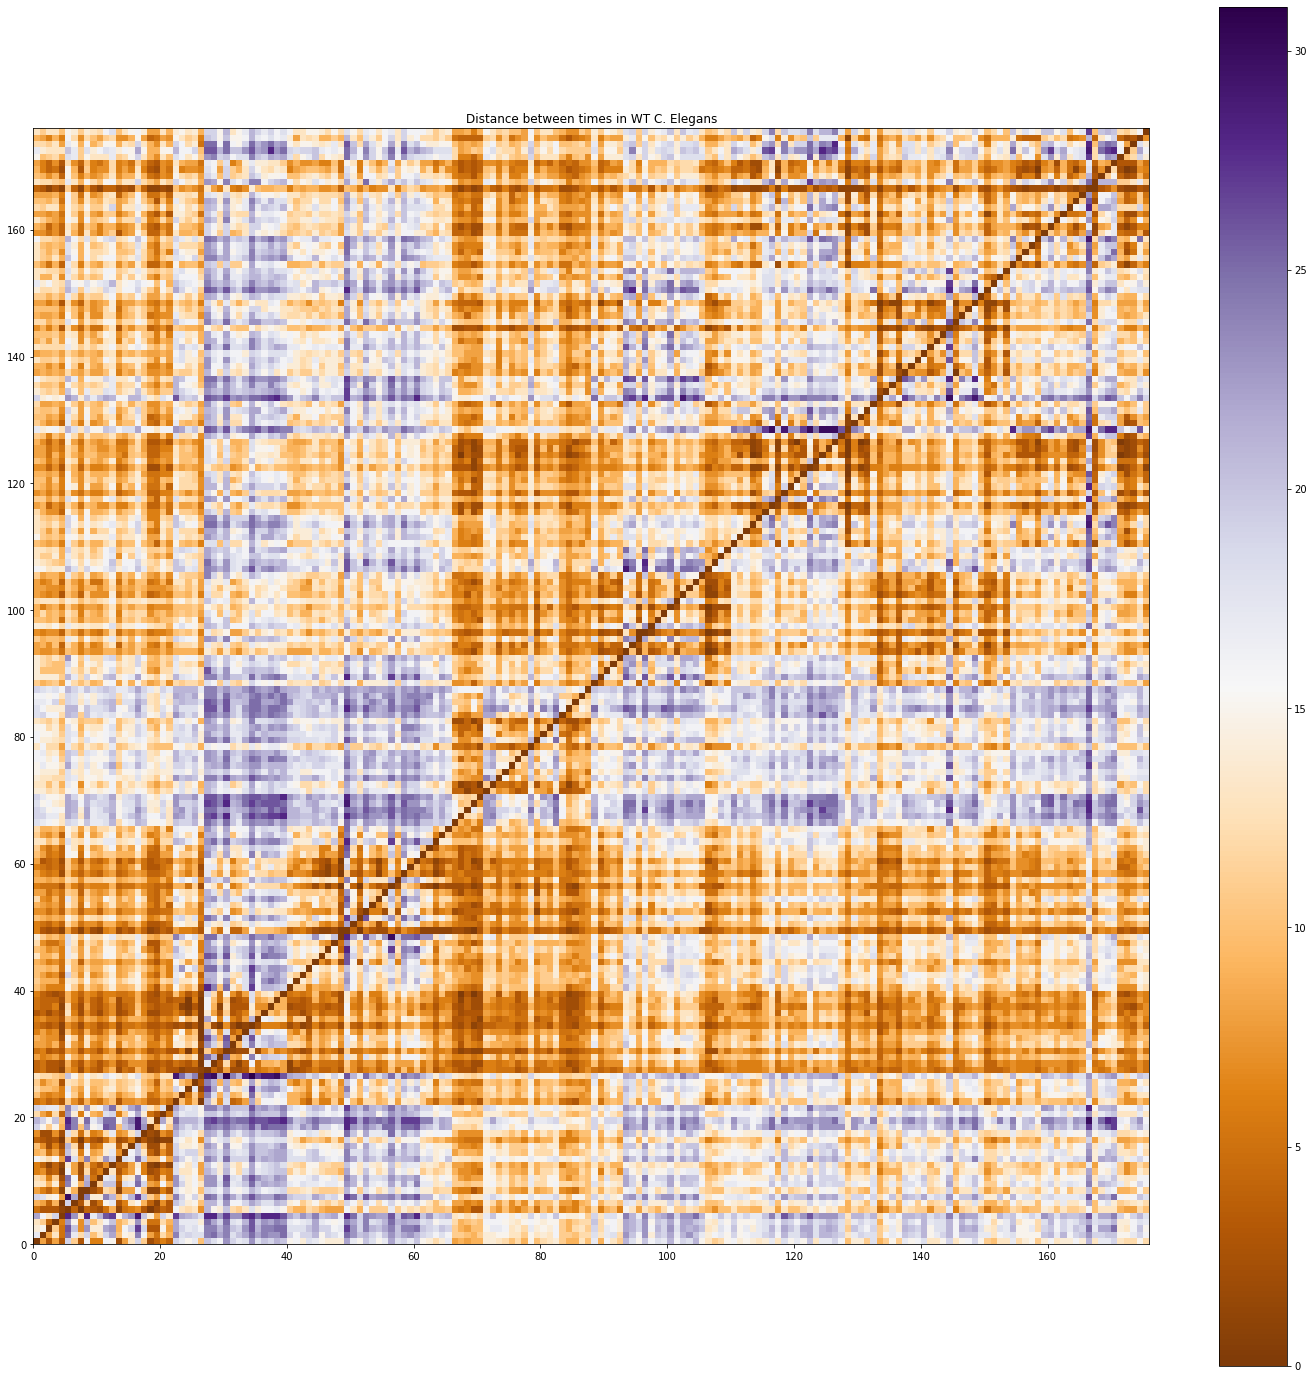

In [180]:
plot_2_examples(['PuOr'],self_b_mat_RNAi_eff[6*22:14*22].T[6*22:14*22])

In [181]:
self_b_mat_RNAi_eff = self_b_mat_RNAi_eff[6*22:14*22].T[6*22:14*22]

In [182]:
self_b_mat_RNAi_eff = self_b_mat_RNAi_eff.T

In [183]:
def third_comp(imp_mat):
    go = np.triu_indices(imp_mat.shape[0],1)
    return imp_mat.T[0:22,0:22][go].tolist() + imp_mat[0:22,0:22][go].tolist() 

In [184]:
#WT_no_notch = third_comp(self_b_mat_RNAi_eff.T[0:22,0:22])+third_comp(self_b_mat_RNAi_eff.T[3*22:4*22,3*22:4*22])+out_comp(self_b_mat_RNAi_eff.T[0:22,3*22:4*22])+out_comp(self_b_mat_RNAi_eff[0:22,3*22:4*22])
WT_notch_ABa = (self_b_mat_RNAi_eff.T[0:22,22:3*22].astype(int)).flatten().tolist() + (self_b_mat_RNAi_eff.T[3*22:4*22,22:3*22].astype(int)).flatten().tolist()
WT_notch_ABp = (self_b_mat_RNAi_eff.T[0:22,4*22:]).flatten().tolist() + (self_b_mat_RNAi_eff.T[3*22:4*22,4*22:]).flatten().tolist()

In [ ]:
WT_no_notch = third_comp(self_b_mat_RNAi_eff.T[0:22,0:22])+third_comp(self_b_mat_RNAi_eff.T[3*22:4*22,3*22:4*22])
out_comp(self_b_mat_RNAi_eff.T[0:22,3*22:4*22])+out_comp(self_b_mat_RNAi_eff[0:22,3*22:4*22])

In [ ]:
list(out_comp(self_b_mat_RNAi_eff.T[0:22,3*22:4*22]))+list(out_comp(self_b_mat_RNAi_eff[0:22,3*22:4*22]))

In [187]:
WT_no_notch = WT_no_notch + list(out_comp(self_b_mat_RNAi_eff.T[0:22,3*22:4*22]))+list(out_comp(self_b_mat_RNAi_eff[0:22,3*22:4*22]))

In [193]:
#plt.hist(self_b_mat_RNAi_eff.T[0:22,3*22:4*22].flatten() + self_b_mat_RNAi_eff[0:22,3*22:4*22].flatten())

In [194]:
def out_comp(imp_mat):
    imp_mat = np.mat(imp_mat).flatten()
    return imp_mat.tolist()[0]

In [195]:
WT_no_notch = third_comp(self_b_mat_RNAi_eff.T[0:22,0:22])+third_comp(self_b_mat_RNAi_eff.T[3*22:4*22,3*22:4*22])+out_comp(self_b_mat_RNAi_eff.T[0:22,3*22:4*22])+out_comp(self_b_mat_RNAi_eff[0:22,3*22:4*22])


(Supplemental Figure 6B) Figure below

(array([ 10.,  19.,  30.,  45.,  44.,  54.,  61.,  65.,  86.,  98., 123.,
        106., 130., 130., 161., 156., 118.,  94.,  82.,  78.,  51.,  41.,
         37.,  25.,  19.,  13.,   4.,   5.,   6.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

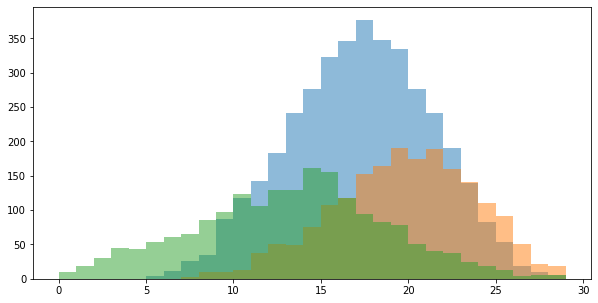

In [196]:
plt.hist(WT_notch_ABp, bins = range(30), alpha = 0.5)
plt.hist(WT_notch_ABa, bins = range(30), alpha = 0.5)
plt.hist(WT_no_notch, bins = range(30), alpha = 0.5)

In [192]:
#(Supplemental Figure 7) Code below

In [197]:
transformation_assignments = {'APX-1': [('ABp', 'ABa')],
 'ATX-2': [('ABp', 'ABa'),
  ('ABar', 'ABal'),
  ('ABala', 'ABara'),
  ('ABara', 'ABala'),
  ('EMS', 'C')],
 'C49H3.8': [('ABala', 'ABara'), ('P2', 'EMS')],
 'CAMT-1': [('ABar', 'ABal'), ('ABara', 'ABala'), ('ABpra', 'ABpla')],
 'CDC-25.1': [('AB', 'ABp'), ('P1', 'P2')],
 'CDC-37': [('ABala', 'ABara'), ('ABalp', 'ABarp'), ('EMS', 'C'), ('P3', 'C')],
 'CEH-24': [('ABa', 'ABp'),
  ('ABar', 'ABal'),
  ('ABala', 'ABara'),
  ('ABarp', 'ABalp'),
  ('ABpla', 'ABpra')],
 'CHAF-2': [('ABala', 'ABara')],
 'CHK-1': [('ABala', 'ABara')],
 'CLS-2': [('AB', 'ABp')],
 'CPL-1': [('ABar', 'ABal'), ('ABala', 'ABara')],
 'CSN-4': [('ABa', 'ABp')],
 'CUL-1': [('ABar', 'ABal'),
  ('ABala', 'ABara'),
  ('MS', 'EMS'),
  ('C', 'EMS'),
  ('P4', 'P3')],
 'CUL-2': [('ABa', 'ABp')],
 'CUL-3': [('ABar', 'ABal'),
  ('ABala', 'ABarp'),
  ('ABpla', 'ABpra'),
  ('ABplp', 'ABpra'),
  ('ABpra', 'ABpla'),
  ('ABprp', 'ABpra')],
 'DIV-1': [('AB', 'ABp'), ('P1', 'P2')],
 'DLC-1': [('ABala', 'ABara')],
 'DLI-1': [('ABala', 'ABara')],
 'DRH-3': [('ABpla', 'ABplp')],
 'F23F1.5': [('ABa', 'ABp')],
 'F35F11.1': [('ABpla', 'ABpra')],
 'F44B9.8': [('EMS', 'C')],
 'GEI-17': [('C', 'MS')],
 'GLD-2': [('ABar', 'ABal'),
  ('ABala', 'ABara'),
  ('ABpra', 'ABpla'),
  ('E', 'MS'),
  ('P4', 'D')],
 'GLP-1': [('ABp', 'ABa'),
  ('ABalp', 'ABarp'),
  ('ABara', 'ABala'),
  ('ABpla', 'ABpra')],
 'GPB-1': [('ABarp', 'ABalp'), ('ABarp', 'ABara')],
 'GSK-3': [('ABar', 'ABal'),
  ('ABala', 'ABara'),
  ('ABpla', 'ABpra'),
  ('E', 'MS'),
  ('C', 'EMS')],
 'HDA-1': [('ABala', 'ABara')],
 'HMP-2': [('ABar', 'ABal')],
 'LAG-1': [('ABp', 'ABa'),
  ('ABalp', 'ABarp'),
  ('ABara', 'ABala'),
  ('ABpla', 'ABpra')],
 'LET-502': [('ABar', 'ABal'), ('ABala', 'ABara'), ('ABpra', 'ABpla')],
 'LIN-23': [('ABar', 'ABal'),
  ('ABpra', 'ABpla'),
  ('MS', 'EMS'),
  ('C', 'EMS'),
  ('P4', 'P3')],
 'MBK-2': [('AB', 'EMS'), ('EMS', 'C')],
 'MEI-1': [('ABar', 'ABal'), ('ABpra', 'ABpla')],
 'MEX-3': [('D', 'P4')],
 'MEX-5': [('AB', 'EMS')],
 'MOM-2': [('ABar', 'ABal'), ('ABpra', 'ABpla'), ('E', 'MS')],
 'MOM-5': [('ABar', 'ABal'), ('ABpra', 'ABpla')],
 'NMY-2': [('ABpla', 'ABpra')],
 'NPP-4': [('ABa', 'ABp'), ('ABpla', 'ABpra')],
 'NUD-1': [('ABala', 'ABara')],
 'OMA-1/2': [('ABar', 'ABal'),
  ('ABalp', 'ABarp'),
  ('ABpra', 'ABpla'),
  ('EMS', 'C')],
 'PAD-1': [('ABpla', 'ABpra')],
 'PAR-2': [('ABp', 'ABa'), ('ABar', 'ABal'), ('P2', 'EMS'), ('E', 'MS')],
 'PAR-3': [('ABar', 'ABal'), ('ABala', 'ABalp;ABara')],
 'PAR-6': [('ABp', 'ABa'),
  ('ABalp', 'ABarp'),
  ('ABara', 'ABala'),
  ('P2', 'EMS'),
  ('E', 'MS')],
 'PIE-1': [('ABp', 'ABa'), ('P2', 'EMS')],
 'PKC-3': [('ABp', 'ABa'), ('ABalp', 'ABarp'), ('P2', 'EMS'), ('E', 'MS')],
 'POP-1': [('ABpla', 'ABpra'), ('MS', 'E')],
 'POS-1': [('ABp', 'ABa'), ('ABar', 'ABal')],
 'PPFR-4': [('ABar', 'ABal'), ('ABpra', 'ABpla')],
 'PUF-3': [('ABar', 'ABal')],
 'RAB-5': [('ABpla', 'ABpra')],
 'RAB-7': [('ABpra', 'ABpla')],
 'RAD-51': [('ABalp', 'ABara')],
 'RAN-4': [('ABa', 'ABp'), ('ABalp', 'ABarp'), ('ABpra', 'ABpla')],
 'RBA-1': [('ABala', 'ABara')],
 'RFC-3': [('AB', 'ABp')],
 'RGA-3': [('ABp', 'ABa'),
  ('ABar', 'ABal'),
  ('ABala', 'ABara'),
  ('ABpla', 'ABpra'),
  ('ABpra', 'ABpla')],
 'RUVB-1': [('ABpla', 'ABpra')],
 'SEL-8': [('ABp', 'ABa'), ('ABalp', 'ABarp'), ('ABara', 'ABala')],
 'SKN-1': [('ABalp', 'ABarp'),
  ('ABara', 'ABala'),
  ('ABpra', 'ABpla'),
  ('EMS', 'C')],
 'SRC-1': [('P4', 'D')],
 'SUF-1': [('ABpla', 'ABpra')],
 'T11G6.8': [('ABalp', 'ABara')],
 'TAG-256': [('ABar', 'ABal'), ('ABpra', 'ABpla')],
 'TAT-5': [('ABar', 'ABal'), ('ABala', 'ABara'), ('ABpra', 'ABpla')],
 'TSR-1': [('EMS', 'C')],
 'UBA-1': [('ABar', 'ABal')],
 'UBC-12': [('ABala', 'ABara'), ('ABarp', 'ABalp')],
 'VPS-4': [('ABala', 'ABara')],
 'WWP-1': [('ABa', 'ABp'), ('ABpla', 'ABpra')],
 'Y53F4B.22': [('ABpla', 'ABpra')],
 'ZYG-11': [('MS', 'EMS')],
 'ZYG-12': [('ABpla', 'ABpra')]}

In [198]:
def scramble_individual(element):
    valuescramble = list(element.values())
    random.shuffle(valuescramble)
    keyscramble = list(element)
    random.shuffle(keyscramble)
    new_element = dict()
    for n in range(0,len(keyscramble)):
        new_element[keyscramble[n]] = valuescramble[n]
    return new_element

scramble_individual(fulldictset[0])

inlier_ref = [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 18, 21, 22, 23, 24, 25, 27, 28, 29]

In [6]:
transformed_sublineages = dict()
hits = 0
for n in transformation_assignments:
    origin = transformation_assignments[n][0][0]
    destination = transformation_assignments[n][0][1]
    #print(origin, destination)
    try:
        for pp in RNAi_size_assignments[n]:
            #print(pp)
            RNAi_org_scram = scramble_individual(node_comparison_trimmer(fulldictset[pp],origin))
            RNAi_org_scram = node_comparison_trimmer(fulldictset[pp],origin)
            #print(RNAi)
            for nn in RNAi_org_scram:
                print(origin + nn, RNAi_org_scram[nn])
                if origin + nn in transformed_sublineages:
                    transformed_sublineages[origin + nn].append(RNAi_org_scram[nn])
                else:
                    transformed_sublineages[origin + nn] = [RNAi_org_scram[nn]]
    except:
        pass

'\ntransformed_sublineages = dict()\nhits = 0\nfor n in transformation_assignments:\n    origin = transformation_assignments[n][0][0]\n    destination = transformation_assignments[n][0][1]\n    #print(origin, destination)\n    try:\n        for pp in RNAi_size_assignments[n]:\n            #print(pp)\n            RNAi_org_scram = scramble_individual(node_comparison_trimmer(fulldictset[pp],origin))\n            RNAi_org_scram = node_comparison_trimmer(fulldictset[pp],origin)\n            #print(RNAi)\n            for nn in RNAi_org_scram:\n                print(origin + nn, RNAi_org_scram[nn])\n                if origin + nn in transformed_sublineages:\n                    transformed_sublineages[origin + nn].append(RNAi_org_scram[nn])\n                else:\n                    transformed_sublineages[origin + nn] = [RNAi_org_scram[nn]]\n    except:\n        pass '

ABaraapap 51.25
ABaraapp 33.75
ABaraappa 48.75
ABaraappp 42.5
ABarap 25.0
ABarapa 27.5
ABarapaa 33.75
ABarapaaa 50.0
ABarapaap 50.0
ABarapap 31.25
ABarapapa 52.5
ABarapapp 41.25
ABarapp 27.5
ABarappa 38.75
ABarappaa 56.25
ABarappap 45.0
ABarappp 32.5
ABarapppa 43.75
ABarapppp 43.75
ABarp 16.25
ABarpa 23.75
ABarpaa 28.75
ABarpaaa 40.0
ABarpaaaa 55.0
ABarpaaap 55.0
ABarpaap 31.25
ABarpaapa 40.0
ABarpaapp 48.75
ABarpap 27.5
ABarpapa 32.5
ABarpapaa 48.75
ABarpapap 47.5
ABarpapp 31.25
ABarpappa 42.5
ABarpappp 42.5
ABarpp 25.0
ABarppa 27.5
ABarppaa 41.25
ABarppaaa 51.25
ABarppaap 51.25
ABarppap 32.5
ABarppapa 43.75
ABarppapp 40.0
ABarppp 26.25
ABarpppa 36.25
ABarpppaa 52.5
ABarpppap 42.5
ABarpppp 32.5
ABarppppa 51.25
ABarppppp 41.25
ABar 13.75
ABara 17.5
ABaraa 26.25
ABaraaa 28.75
ABaraaaa 37.5
ABaraaaaa 38.75
ABaraaaap 43.75
ABaraaap 32.5
ABaraaapa 41.25
ABaraaapp 41.25
ABaraap 28.75
ABaraapa 37.5
ABaraapaa 48.75
ABaraapap 46.25
ABaraapp 35.0
ABaraappa 46.25
ABaraappp 43.75
ABarap 26.25
ABa

ABpaaaa 27.5
ABpaaaaa 40.0
ABpaaaaaa 51.25
ABpaaaaap 47.5
ABpaaaap 33.75
ABpaaaapa 43.75
ABpaaaapp 51.25
ABpaaap 27.5
ABpaaapa 38.75
ABpaaapaa 42.5
ABpaaapap 47.5
ABpaaapp 33.75
ABpaaappa 46.25
ABpaaappp 46.25
ABpaap 21.25
ABpaapa 28.75
ABpaapaa 40.0
ABpaapaaa 60.0
ABpaapaap 45.0
ABpaapap 31.25
ABpaapapa 45.0
ABpaapapp 45.0
ABpaapp 26.25
ABpaappa 33.75
ABpaappaa 51.25
ABpaappap 47.5
ABpaappp 32.5
ABpaapppa 52.5
ABpaapppp 42.5
ABpap 16.25
ABpapa 21.25
ABpapaa 27.5
ABpapaaa 37.5
ABpapaaaa 48.75
ABpapaaap 51.25
ABpapaap 31.25
ABpapaapa 40.0
ABpapaapp 50.0
ABpapap 26.25
ABpapapa 33.75
ABpapapaa 48.75
ABpapapap 48.75
ABpapapp 31.25
ABpapappa 45.0
ABpapappp 45.0
ABpapp 21.25
ABpappa 25.0
ABpappaa 41.25
ABpappaaa 53.75
ABpappaap 47.5
ABpappap 32.5
ABpappapa 45.0
ABpappapp 40.0
ABpappp 26.25
ABpapppa 35.0
ABpapppaa 52.5
ABpapppap 45.0
ABpapppp 32.5
ABpappppa 47.5
ABpappppp 40.0
ABpp 13.75
ABppa 16.25
ABppaa 22.5
ABppaaa 26.25
ABppaaaa 35.0
ABppaaaaa 47.5
ABppaaaap 47.5
ABppaaap 30.0
ABppaaapa 

ABppppp 26.25
ABpppppa 33.75
ABpppppaa 51.25
ABpppppap 45.0
ABpppppp 31.25
ABppppppa 45.0
ABppppppp 38.75
ABp 13.75
ABpa 18.75
ABpaa 20.0
ABpaaa 28.75
ABpaaaa 35.0
ABpaaaaa 41.25
ABpaaaap 50.0
ABpaaap 31.25
ABpaaapa 40.0
ABpaaapp 40.0
ABpaap 28.75
ABpaapa 31.25
ABpaapaa 43.75
ABpaapap 40.0
ABpaapp 32.5
ABpaappa 46.25
ABpaappp 41.25
ABpap 20.0
ABpapa 27.5
ABpapaa 35.0
ABpapaaa 48.75
ABpapaap 41.25
ABpapap 32.5
ABpapapa 41.25
ABpapapp 38.75
ABpapp 27.5
ABpappa 32.5
ABpappaa 46.25
ABpappap 37.5
ABpappp 32.5
ABpapppa 41.25
ABpapppp 37.5
ABpp 17.5
ABppa 21.25
ABppaa 28.75
ABppaaa 37.5
ABppaaaa 50.0
ABppaaap 42.5
ABppaap 33.75
ABppaapa 46.25
ABppaapp 45.0
ABppap 28.75
ABppapa 33.75
ABppapaa 46.25
ABppapap 41.25
ABppapp 33.75
ABppappa 46.25
ABppappp 43.75
ABppp 21.25
ABpppa 27.5
ABpppaa 35.0
ABpppaaa 38.75
ABpppaap 48.75
ABpppap 33.75
ABpppapa 41.25
ABpppapp 37.5
ABpppp 27.5
ABppppa 32.5
ABppppaa 42.5
ABppppap 48.75
ABppppp 32.5
ABpppppa 40.0
ABpppppp 37.5
ABpla 15.0
ABplaa 22.5
ABplaaa 25.0


ABalappa 77.5
ABalappp 65.0
ABala 21.25
ABalaa 36.25
ABalaaa 52.5
ABalaaaa 77.5
ABalaaap 66.25
ABalaap 52.5
ABalaapa 67.5
ABalaapp 70.0
ABalap 35.0
ABalapa 48.75
ABalapaa 68.75
ABalapap 65.0
ABalapp 52.5
ABalappa 77.5
ABalappp 77.5
ABala 18.75
ABalaa 31.25
ABalaaa 45.0
ABalaaaa 62.5
ABalaaap 57.5
ABalaap 45.0
ABalaapa 57.5
ABalaapp 56.25
ABalap 31.25
ABalapa 42.5
ABalapaa 55.0
ABalapap 50.0
ABalapp 42.5
ABalappa 60.0
ABalappp 47.5
ABala 20.0
ABalaa 31.25
ABalaaa 43.75
ABalaaaa 61.25
ABalaaap 56.25
ABalaap 42.5
ABalaapa 57.5
ABalaapp 52.5
ABalap 31.25
ABalapa 41.25
ABalapaa 51.25
ABalapap 46.25
ABalapp 42.5
ABalappa 56.25
ABalappp 53.75
ABala 18.75
ABalaa 36.25
ABalaaa 52.5
ABalaaaa 82.5
ABalaaap 76.25
ABalaap 48.75
ABalaapa 65.0
ABalaapp 61.25
ABalap 35.0
ABalapa 48.75
ABalapaa 62.5
ABalapap 62.5
ABalapp 50.0
ABalappa 63.75
ABalappp 56.25
ABala 18.75
ABalaa 36.25
ABalaaa 48.75
ABalaaaa 65.0
ABalaaap 60.0
ABalaap 47.5
ABalaapa 72.5
ABalaapp 61.25
ABalap 33.75
ABalapa 46.25
ABalapaa 63.7

ABpaapap 32.5
ABpaapp 28.75
ABpaappa 36.25
ABpaappp 40.0
ABpap 17.5
ABpapa 26.25
ABpapaa 28.75
ABpapaaa 36.25
ABpapaaaa 46.25
ABpapaaap 48.75
ABpapaap 36.25
ABpapaapa 50.0
ABpapaapp 45.0
ABpapap 28.75
ABpapapa 36.25
ABpapapp 32.5
ABpapp 26.25
ABpappa 30.0
ABpappaa 38.75
ABpappap 38.75
ABpappapa 48.75
ABpappapp 50.0
ABpappp 30.0
ABpapppa 35.0
ABpapppp 35.0
ABpp 12.5
ABppa 16.25
ABppaa 26.25
ABppaaa 28.75
ABppaaaa 38.75
ABppaaap 36.25
ABppaap 28.75
ABppaapa 33.75
ABppaapp 33.75
ABppap 26.25
ABppapa 28.75
ABppapaa 37.5
ABppapaaa 47.5
ABppapaap 52.5
ABppapap 33.75
ABppapp 28.75
ABppappa 36.25
ABppappp 40.0
ABppp 17.5
ABpppa 25.0
ABpppaa 30.0
ABpppaaa 37.5
ABpppaaaa 45.0
ABpppaaap 47.5
ABpppaap 36.25
ABpppaapa 50.0
ABpppaapp 48.75
ABpppap 28.75
ABpppapa 36.25
ABpppapp 35.0
ABpppp 27.5
ABppppa 30.0
ABppppaa 40.0
ABppppap 37.5
ABppppapa 45.0
ABppppapp 50.0
ABppppp 28.75
ABpppppa 35.0
ABpppppp 35.0
ABp 6.25
ABpa 12.5
ABpaa 15.0
ABpaaa 23.75
ABpaaaa 28.75
ABpaaaaa 37.5
ABpaaaap 33.75
ABpaaap 27

ABarpaaa 65.0
ABarpaaaa 73.75
ABarpaaap 66.25
ABarpaap 53.75
ABarpaapa 62.5
ABarpaapp 63.75
ABarpap 42.5
ABarpapa 73.75
ABarpapp 67.5
ABarpappa 67.5
ABarpappp 71.25
ABarpp 35.0
ABarppa 38.75
ABarppaa 65.0
ABarppap 55.0
ABarppp 43.75
ABarpppa 67.5
ABarpppp 58.75
ABar 13.75
ABara 16.25
ABaraa 43.75
ABaraaa 47.5
ABaraaaa 73.75
ABaraaap 53.75
ABaraaapa 65.0
ABaraaapp 71.25
ABaraap 52.5
ABaraapa 56.25
ABaraapaa 66.25
ABaraapap 71.25
ABaraapp 56.25
ABaraappa 65.0
ABaraappp 66.25
ABarap 32.5
ABarapa 42.5
ABarapaa 66.25
ABarapaaa 76.25
ABarapaap 63.75
ABarapap 58.75
ABarapapa 75.0
ABarapapp 76.25
ABarapp 46.25
ABarappa 61.25
ABarappp 55.0
ABarp 16.25
ABarpa 36.25
ABarpaa 51.25
ABarpaaa 62.5
ABarpaap 56.25
ABarpap 43.75
ABarpapa 72.5
ABarpapp 61.25
ABarpp 35.0
ABarppa 42.5
ABarppaa 67.5
ABarppap 57.5
ABarppp 42.5
ABarpppa 62.5
ABarpppp 60.0
ABala 18.75
ABalaa 32.5
ABalaaa 40.0
ABalaaaa 45.0
ABalaaap 45.0
ABalaap 36.25
ABalaapa 48.75
ABalaapp 47.5
ABalap 32.5
ABalapa 31.25
ABalapaa 50.0
ABalapap

In [31]:
inlier_ref = [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 18, 21, 22, 23, 24, 25, 27, 28, 29]

diameters = []
for n in root_cells_comp:
    diam_temp = 0
    for m in inlier_ref:
        q = node_comparison_trimmer(fulldictset[m],n)
        for l in inlier_ref:
            r = node_comparison_trimmer(fulldictset[l],n)
            #print(n,m,l)
            diam_temp = max(union_branch_distance(q,r), diam_temp)
    diameters.append(diam_temp)
    #print(n,diam_temp)

In [ ]:
WT_lineages_truncated = []
for m in root_cells_comp:
    WT_lineages_truncated_0 = []
    for n in inlier_ref:
        print(n,m)
        WT_lineages_truncated_0.append(node_comparison_trimmer(fulldictset[n],m))
    WT_lineages_truncated.append(WT_lineages_truncated_0)

In [ ]:
WT_lineages_truncated_dict = dict()
for n in range(len(WT_lineages_truncated)):
    print(n, root_cells_comp[n] ,len(WT_lineages_truncated[n]))
    WT_lineages_truncated_dict[root_cells_comp[n]] = WT_lineages_truncated[n]

In [ ]:
inlier_ref = [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 18, 21, 22, 23, 24, 25, 27, 28, 29]

bit= 0
transformation_assignments_counter = []
for n in transformation_assignments:
    for nn in transformation_assignments[n]:
        origin = transformation_assignments[n][0][0]
        destination = transformation_assignments[n][0][1]
        for nnn in RNAi_size_assignments[n]:
            bit = bit + 1
            #print(n,origin,destination,nnn)
            RNAi_org_scram = node_comparison_trimmer(fulldictset[nnn],origin)
            RNAi_org_scram_2 = dict()
            for nnnn in list(RNAi_org_scram):
                RNAi_org_scram_2[nnnn] = random.choice(transformed_sublineages[origin + nnnn])
            hits = 0
            for qq in inlier_ref:
                WT_dest_raw = node_comparison_trimmer(fulldictset[qq],destination)
                try:
                    print(diameters[root_cells_comp.index(destination)])
                    if union_branch_distance(RNAi_org_scram_2, WT_dest_raw) < diameters[root_cells_comp.index(destination)]:
                        hits = hits + 1
                except:
                    pass
            transformation_assignments_counter.append(hits)

In [ ]:
#replace 10000 with the number of iterations
bit = 0
perm_test_HT = [];perm_test_HT_22 = []
for bbb in range(10000):
    if bbb % 50 == 0: print(bbb)
    transformation_assignments_counter = []
    for n in transformation_assignments:
        for nn in transformation_assignments[n]:
            origin = transformation_assignments[n][0][0]
            destination = transformation_assignments[n][0][1]
            for nnn in RNAi_size_assignments[n]:
                bit = bit + 1
                RNAi_org_scram = node_comparison_trimmer(fulldictset[nnn],origin)
                RNAi_org_scram_2 = dict()
                for nnnn in list(RNAi_org_scram):
                    RNAi_org_scram_2[nnnn] = random.choice(transformed_sublineages[origin + nnnn])
                hits = 0
                #deedeedee = diameters[root_cells_comp.index(destination)]
                try:
                    deedeedee = diameters[root_cells_comp.index(destination)]
                    #print(deedeedee)
                    for qq in WT_lineages_truncated_dict[destination]:
                        #WT_dest_raw = qq
                        UBD = union_branch_distance(RNAi_org_scram_2, qq)
                        #print()
                        #print(UBD, deedeedee)
                        if UBD < deedeedee:
                            hits = hits + 1
                        elif UBD > 2 * deedeedee:
                            break
                    transformation_assignments_counter.append(hits)
                except:
                    pass
    transformation_assignments_counter = np.array(transformation_assignments_counter)
    perm_test_HT.append(np.count_nonzero(transformation_assignments_counter))
    perm_test_HT_22.append(np.count_nonzero(transformation_assignments_counter == 22))
    #print( len(transformation_assignments_counter) , np.count_nonzero(transformation_assignments_counter ) , np.count_nonzero(transformation_assignments_counter == 22))


(Supplemental Figure 7B) Figure below

In [ ]:
plt.hist(transformation_assignments_counter, bins = range(0,24), edgecolor = 'black')
plt.savefig('Fig7B.svg', format = 'svg')

In [ ]:
len(full_counter) - 4

In [ ]:
plt.hist(full_counter, bins = range(1,22), edgecolor = 'black')
plt.savefig('Fig7F.svg', format = 'svg')

(Supplemental Figure 7C) Figure below

In [ ]:
plt.hist(perm_test_HT_22, bins = range(0,20), edgecolor = 'black')
plt.plot([15,15], [0,8000], c = 'r')
plt.savefig('Fig7C.svg', format = 'svg')
#plt.xlabel("Number of shuffled homeotic transformations with 22 WT lineage neighbors ")

(Supplemental Figure 7D) Figure below

In [ ]:
plt.hist(perm_test_HT, bins = range(0,100), edgecolor = 'black')
plt.plot([82,82], [0,8000], c = 'r')
plt.savefig('Fig7D.svg', format = 'svg')
#plt.xlabel("Number of shuffled homeotic transformations with 1+ WT lineage neighbors ")

In [ ]:
#REFERENCE_ME
All_Rand_neighbors = []; All_Rand_neighbors_22 = []; 

In [ ]:
#print("Knocked Down Gene, embryo, sublineage, number of WT neighbors, WT neighbor sublineages")
deliberations = 10000
for klep in range(0,deliberations):
    #f.write("Knocked Down Gene, embryo, sublineage, number of WT neighbors, WT neighbor sublineages")
    full_counter = []
    for an in range(len(fulldictset))[30:]:
        #if an % 50: print(an/len(fulldictset))
        n = fulldictset[an]
        for m in root_cells_comp:
            #if RNAi_name_array[an] in transformation_assignments_format and m in transformation_assignments_format[RNAi_name_array[an]]:
            #    continue
            unperturbed = n#node_comparison_trimmer(n, m)
            shuffled = dict()
            for lol in unperturbed:
                #print(lol, unperturbed[lol])
                try:
                    #print()
                    shuffled[lol] = random.choice(fulldictset[30:])[lol]
                    #shuffled[lol] = cracked_dict_2[lol][0]
                except:
                    shuffled[lol] = 0
                    #print(0)
            unperturbed = node_comparison_trimmer(shuffled, m)
            max_val = 0; max_lin = ""
            for nn in range(len(WT_lineages_truncated)):
                counter = 0
                for nnn in range(len(WT_lineages_truncated[0])):
                    ubed = union_branch_distance(unperturbed,WT_lineages_truncated[nn][nnn] )
                    if ubed <= diameters[nn]:
                        counter = counter + 1;
                    elif ubed > 2 * diameters[nn]:
                        break
                if counter > max_val:
                    max_val = counter; 
            full_counter.append(max_val)
    full_counter = np.array(full_counter)
    #break
    #print(, )
    All_Rand_neighbors.append(np.count_nonzero(full_counter))
    All_Rand_neighbors_22.append(np.count_nonzero(full_counter == 22))
    #if klep % 5 == 0: print(klep / deliberations)

            #print()

In [ ]:
np.histogram(full_counter)

In [ ]:
plt.hist(All_Rand_neighbors_22, bins = range(0,500), edgecolor = 'black')
plt.plot([452,452],[0,10000], c = 'r')
plt.savefig('Fig7G.svg', format = 'svg')

In [ ]:
plt.hist(All_Rand_neighbors, bins = range(0,2500), edgecolor = 'black')
plt.plot([2076,2076],[0,1500], c = 'r')
plt.savefig('Fig7H.svg', format = 'svg')

In [ ]:
np.count_nonzero(np.array(full_counter) == 0)

(Supplemental Figure 7F) Figure below

In [ ]:
np.histogram(full_counter)

In [ ]:

#plt.xlabel("Number of WT Neighbors of all shuffled lineages ")

(Supplemental Figure 7G) Figure below

In [ ]:
plt.hist(All_Rand_neighbors_22, bins = range(0,800))
plt.plot([452,452], [0,10], c = 'r')
plt.xlabel("Number of shuffled RNAi lineages with 22 WT lineage neighbors ")

(Supplemental Figure 7H) Figure below

In [ ]:
plt.hist(All_Rand_neighbors, bins = range(0,3000))
plt.plot([2076,2076], [0,10], c = 'r')
plt.xlabel("Number of shuffled RNAi lineages with 1+ WT lineage neighbors ")

In [34]:
diameter_dict = dict()
for n in range(len(diameters)):
    #print(n, , )
    diameter_dict[root_cells_comp[n]] = diameters[n]

In [ ]:
f = open("S4_Dataset.txt", "w")
f.write("Knocked Down Gene, embryo number, RNAi embryo sublineage, number of WT neighbors, largest WT neighbor sublineage\n")
for genes in list(RNAi_size_assignments)[2:]:
    print(genes)
    for embryo_count in RNAi_size_assignments[genes]:
        RNAi_embryo = fulldictset[embryo_count]
        for root_sublineages in root_cells_comp:
            RNAi_embryo_truncated = node_comparison_trimmer(RNAi_embryo,root_sublineages)
            neighbor_count = []; WT_neighbor_labels = []
            #print(genes, embryo_count, root_sublineages)
            for WT_lineages in WT_lineages_truncated_dict:
                counting_WT_neighbors = 0
                for WT_embryo in WT_lineages_truncated_dict[WT_lineages]:
                    breaker_distance = union_branch_distance(WT_embryo,RNAi_embryo_truncated)
                    if breaker_distance > 2 * diameter_dict[WT_lineages]:
                        break
                    #print(breaker_distance, diameter_dict[WT_lineages])
                    counting_WT_neighbors += (breaker_distance < diameter_dict[WT_lineages])
                if counting_WT_neighbors > 0:
                    #print(genes, embryo_count, root_sublineages, WT_lineages, counting_WT_neighbors)
                    WT_neighbor_labels.append(WT_lineages); neighbor_count.append(counting_WT_neighbors)
            #print(genes, embryo_count, root_sublineages)
            #print(neighbor_count,WT_neighbor_labels)
            if len(neighbor_count) == 0:
                f.write(genes+", "+str(embryo_count)+", "+root_sublineages+", (No WT neighbors)\n")
            else:
                neighbor_count_select = max(neighbor_count)
                WT_neighbor_labels_select = np.array(WT_neighbor_labels)[np.where(neighbor_count == neighbor_count_select)]
                #print(genes, embryo_count, root_sublineages,neighbor_count,WT_neighbor_labels)
                f.write(genes+", "+str(embryo_count)+", "+root_sublineages+", "+str(neighbor_count_select)+", "+str(WT_neighbor_labels_select)+"\n")
                #f.write(genes, embryo_count, root_sublineages,neighbor_count_select,WT_neighbor_labels_select)
f.close()

In [ ]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=55)
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 25)
    plt.savefig("BD_WT.svg", format = 'svg', dpi=300)
    plt.show()

In [ ]:
plot_2_examples(['hot_r'],AB8_reference)

In [ ]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=55)
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 25)
    plt.savefig("GBD.svg", format = 'svg', dpi=300)
    plt.show()

In [ ]:
plot_2_examples(['hot_r'],AB8_PBD)

In [ ]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=1)
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 25)
    plt.show()

In [ ]:
plot_2_examples(['Greens'],np.nan_to_num( (AB8_reference - AB8_PBD) / AB8_reference ))

In [ ]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0))
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 25)
    plt.show()

In [ ]:
plot_2_examples(['Blues'],AB8_Switched_Nodes/len(refsamp2))

In [ ]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=1)
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 25)
    plt.savefig("SwappedNodes.svg", format = 'svg', dpi=300)
    plt.show()